| **№**           | **Задача**      |                       **Подзадача**                     | **Стадия** |
| ----------- |:-----------| :-----------|:-----------:|
| 1           | **Датасет**                                     | 1.1 Выбор датасета       | ✓ |
| 2         | **Исследование и прототипирование в Jupyter Notebook**|2.1 Исследование, предобработка, визуализация данных | ✓ |
|             |                                                      | 2.2 Feature Engineering | ✓ |
|             |                                                   | 2.3 Прототип модели, ее обучение и тестирование | ✓ |
| 3           | **Разработка модели и валидация**                      | 3.1 Кросс-валидация | ✓ |
|             |                                                    | 3.2 Настройка гиперпараметров             | ✓ |
|             |                                                    | 3.3 Окончательная версия модели| ✓ |
| 4           | **Развертывание модели с FastAPI**                     | 4.1 Создание веб-сервиса с FastAPI | ✓ |
|             |                                                        | 4.2 Два типа запросов              | ✓ |
| 5           | **Контейнеризация с Docker**                           | 5.1 Docker-контейнер | ✓ |
|             |                                                    | 5.2 Dockerfile       | ✓ |
| 6           | **Размещение на Github и документация**                | 6.1 Размещение на GitHub | ✓ |
|             |                                                    | 6.2 README.md файл       | ✓ |

# 1 Выбор датасета

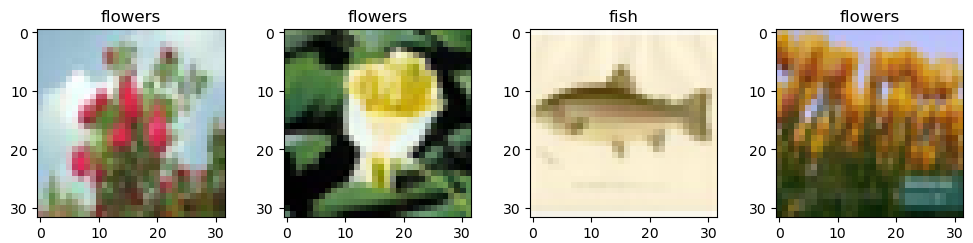

В данной работе выбран датасет **CIFAR-100 Python**, который представляет собой коллекцию изображений для тренировки алгоритмов компьютерного зрения. [Ссылка на датасет] (https://www.kaggle.com/datasets/fedesoriano/cifar100/data)  

Задача заключается в том, чтобы распознать изображение и указать его **группу**, т.е. предполагается задача классификации.

- Первоначальный набор данных CIFAR-100 состоит из 60 000 цветных изображений размером 32x32 пикселя в 100 классах, по 600 изображений в каждом классе. 100 классов (classes) CIFAR-100 сгруппированы в 20 групп (superclasses).  
- Каждое изображение имеет «fine» метку (класс, к которому оно принадлежит) и **«coarse»** метку (группа, к которому оно принадлежит).  
- В данной работе для исследования выбраны две группы для распознавания: **цветы и рыбы**.

# 2 Исследование и прототипирование

## 2.1 Загрузка набора данных и EDA исследование

In [1]:
# Для начала импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from termcolor import colored
from PIL import Image
import cv2
import csv
import random
import pickle

#### Извлечение базы данных

In [2]:
# Загрузка данных
# Функция, используемая для открытия каждого файла:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Считываем метаданные набора данных
metadata_path = r"C:\texlive5\phd\DataScience_Study\My_Project_Animals\Dataset\meta"
metadata = unpickle(metadata_path)
meta = metadata[b'coarse_label_names']
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

In [4]:
# Посмотрим, что включают в себя метаданные 'групп' (superclasses) изображений нашего набора данных
meta

[b'aquatic_mammals',
 b'fish',
 b'flowers',
 b'food_containers',
 b'fruit_and_vegetables',
 b'household_electrical_devices',
 b'household_furniture',
 b'insects',
 b'large_carnivores',
 b'large_man-made_outdoor_things',
 b'large_natural_outdoor_scenes',
 b'large_omnivores_and_herbivores',
 b'medium_mammals',
 b'non-insect_invertebrates',
 b'people',
 b'reptiles',
 b'small_mammals',
 b'trees',
 b'vehicles_1',
 b'vehicles_2']

In [5]:
# Определяем путь к набору данных и загружаем соответствующий файл:
data_train_path = r"C:\texlive5\phd\DataScience_Study\My_Project_Animals\Dataset\train"
data_train_dict = unpickle(data_train_path)

data_test_path = r"C:\texlive5\phd\DataScience_Study\My_Project_Animals\Dataset\test"
data_test_dict = unpickle(data_test_path)

In [6]:
# Извлекаем из общего датасета набор данных, разбитый по 20 группам 'coarse_labels'
X_train = data_train_dict[b'data']
y_train = np.array(data_train_dict[b'coarse_labels'])

X_test = data_test_dict[b'data']
y_test = np.array(data_test_dict[b'coarse_labels'])

In [7]:
# Посмотрим, что представляют из собой сформированные данные на примере X_train и y_train
X_train, y_train

(array([[255, 255, 255, ...,  10,  59,  79],
        [255, 253, 253, ..., 253, 253, 255],
        [250, 248, 247, ..., 194, 207, 228],
        ...,
        [248, 240, 236, ..., 180, 174, 205],
        [156, 151, 151, ..., 114, 107, 126],
        [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8),
 array([11, 15,  4, ...,  8,  7,  1]))

X_train - массив из значений от 0 до 255;   
y_train - массив из числовых значений групп изображений (от 0 до 19)

In [8]:
# Посмотрим размерность датасетов
X_train.shape, y_train.shape

((50000, 3072), (50000,))

Исходный набор тренировочных данных состоит из 50000 изображений, каждое из которых имеет размерность 3072 пикселей

<Axes: ylabel='Class'>

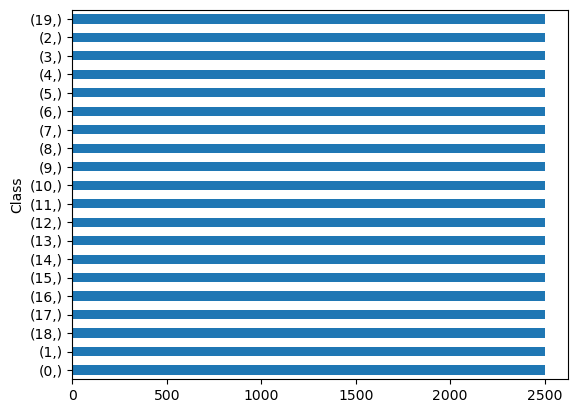

In [9]:
# Проверим баланс между группами в выборке
y_train_bal = pd.DataFrame(y_train, columns=['Class'])
y_train_bal.value_counts().plot.barh()

Как можно заметить, все группы представлены в датасете в одинаковом количестве

#### Отбор данных по группам "рыбы" (1) и "цветы" (2)   
Отберем для исследования только две группы изображений:   
- рыбы (классы 6-10) (группа 1 согласно массиву данных)  
- цветы (классы 11-15) (группа 2 согласно массиву данных)

In [10]:
# ВЫДЕЛЯЕМ ГРУППЫ ИЗ ТРЕНИРОВОЧНОГО НАБОРА ДАННЫХ
# Оформим все компоненты исходного словаря с данными в датафреймы
X_train_o = pd.DataFrame(data=X_train)
y_train_o = pd.DataFrame(y_train, columns=['Superclass'])
name_train_o = pd.DataFrame(np.array(data_train_dict[b'filenames']), columns=['File_name'])

# Объединим все датафремы в один
df_new_train = pd.concat([name_train_o, y_train_o, X_train_o], axis=1)

# Отсортируем данные по двум группам (рыбы и цветы)
df_1_train = df_new_train[(df_new_train['Superclass'] == 1) | (df_new_train['Superclass'] == 2)]

# Разделяем данные на признаки и целевые метрики
df10_train = df_1_train[['File_name']]
df11_train = df_1_train[['Superclass']]
df12_train = df_1_train.iloc[:, 2:]


# ВЫДЕЛЯЕМ ГРУППЫ ИЗ ТЕСТОВОГО НАБОРА ДАННЫХ
# Оформим все компоненты исходного словаря с данными в датафреймы
X_test_o = pd.DataFrame(data=X_test)
y_test_o = pd.DataFrame(y_test, columns=['Superclass'])
name_test_o = pd.DataFrame(np.array(data_test_dict[b'filenames']), columns=['File_name'])

# Объединим все датафремы в один
df_new_test = pd.concat([name_test_o, y_test_o, X_test_o], axis=1)

# Отсортируем данные по двум группам (рыбы и цветы)
df_1_test = df_new_test[(df_new_test['Superclass'] == 1) | (df_new_test['Superclass'] == 2)]

# Разделяем данные на признаки и целевые метрики
df10_test = df_1_test[['File_name']]
df11_test = df_1_test[['Superclass']]
df12_test = df_1_test.iloc[:, 2:]

#### Итоговый набор данных (тренировочный - train, тестовый - test, валидационный - val)
Определим итоговые наборы данных для дальнейшего обучения моделей.

In [11]:
# Тренировочный набор данных          #
X1_train = df12_train                 #
y1_train = df11_train                 #DataFrame
# Тестовый набор данных               # 
X1_test = df12_test                   #
y1_test = df11_test                   #

In [12]:
X1_train.shape

(5000, 3072)

In [13]:
# Выделим из тренировочного набора данных валидационную группу (для оценки модели после корректировки гиперпараметров)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.2, random_state=42)

In [14]:
# Проверим сколько элементов включает в себя каждый набор данных
X1_train.shape, X1_val.shape, X1_test.shape

((4000, 3072), (1000, 3072), (1000, 3072))

Получается, что все исходные данные мы разделили в следующих пропорциях: тренировочные - 60%, валидационные - 20%, тестовые - 20%

In [15]:
# Сохраним также исходные метрики в виде массивов
X1_train_arr = X1_train.to_numpy ()    #
y1_train_arr = y1_train.to_numpy ()    #
X1_val_arr = X1_val.to_numpy ()        # array
y1_val_arr = y1_val.to_numpy ()        #
X1_test_arr = X1_test.to_numpy ()      #
y1_test_arr = y1_test.to_numpy ()      #

In [16]:
# Сохраним также исходные метрики для дальнейшей оценки RGB параметров
X1rgb_train = X1_train   
X1rgb_val = X1_val    
X1rgb_test = X1_test   

In [17]:
# Получим базовую информацию об итоговом наборе данных

print (colored('X1_train', 'yellow'))
X1_train.info()
print (colored('X1_val', 'yellow'))
X1_val.info()
print (colored('X1_test', 'yellow'))
X1_test.info()
print (colored('y1_train', 'yellow'))
y1_train.info()
print (colored('y1_val', 'yellow'))
y1_val.info()
print (colored('y1_test', 'yellow'))
y1_test.info()
print()

X1_train
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 41803 to 8560
Columns: 3072 entries, 0 to 3071
dtypes: uint8(3072)
memory usage: 11.7 MB
X1_val
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 14979 to 18868
Columns: 3072 entries, 0 to 3071
dtypes: uint8(3072)
memory usage: 2.9 MB
X1_test
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 5 to 9999
Columns: 3072 entries, 0 to 3071
dtypes: uint8(3072)
memory usage: 2.9 MB
y1_train
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 41803 to 8560
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Superclass  4000 non-null   int32
dtypes: int32(1)
memory usage: 46.9 KB
y1_val
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 14979 to 18868
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Superclass  1000 non-null   int32
dtypes: int32(1)
memory usage: 11.7 K

- Итоговый датасет состоит из **6000 записей (строк)** (4000 в тренировочном (train), 1000 в тестовом (test) и 1000 в валидационном (val)) и **3072 колонок (признаков)**, которые описывают размер изображения в пикселях (32х32х3) и глубину цвета.
- Большая часть данных представлена целыми числами (**int**).
- **Пропущенные значения отсутствуют** (non-null), что говорит о том, что датасет полностью заполнен и готов к анализу без необходимости предварительной обработки пропусков.
- Память, занимаемая датасетом, составляет **< 20 MB**.

In [18]:
# Сохраним наши преобразованные данные
X1_train.to_parquet('X_train.parq')
X1_test.to_parquet('X_test.parq')
y1_train.to_parquet('y_train.parq')
y1_test.to_parquet('y_test.parq')

## 2.2 Визуализация

Проверим достоверность изображений и обозначение соответствующей группы, путем визуализации. 

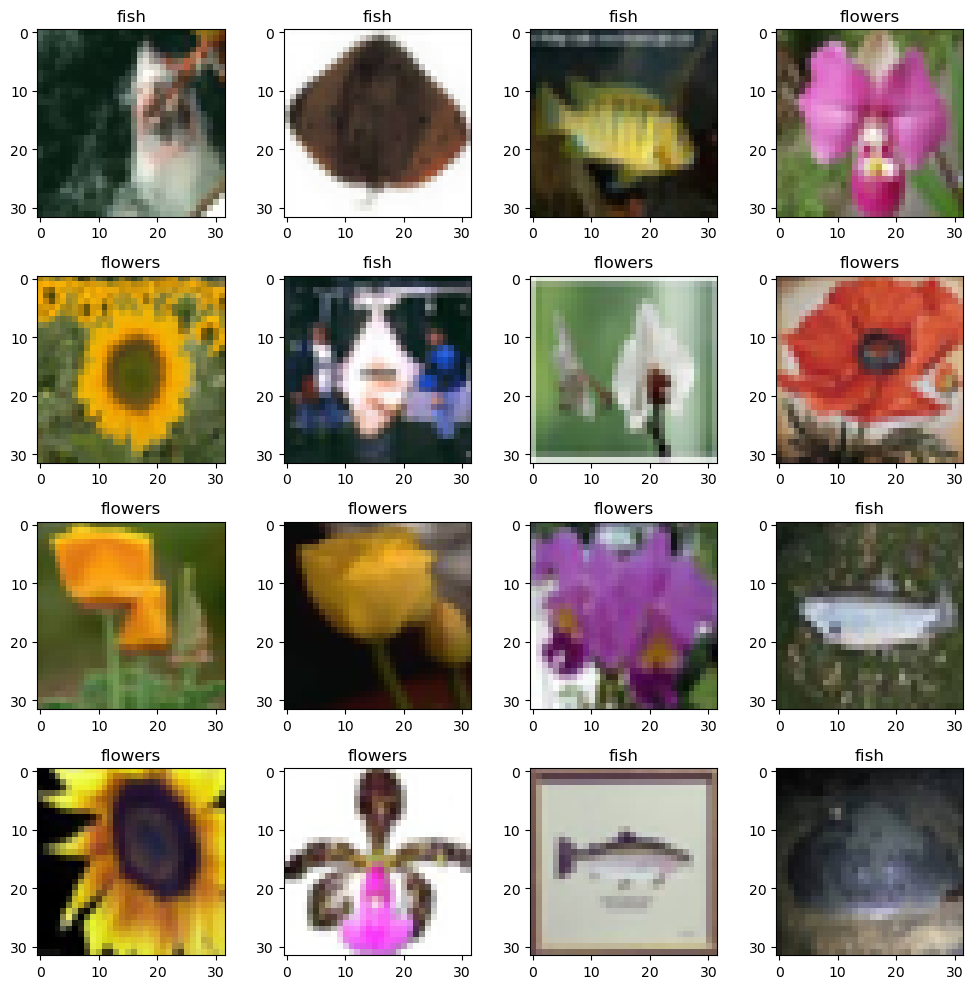

In [19]:
# Исходное количество групп (superclasses) в файле с метаданными
nclass = 20
# Приведем значения групп (superclasses) к двоичной классификации
# Используем команду numpy.eye, которая возвращает двумерный массив с единицами по диагонали
# и нулями в остальных значениях матрицы.
y1_train_cat = np.eye(nclass)[y1_train]

# Переведем данные в формат (32, 32, 3)
X101_train_arr = X1_train_arr.reshape(len(X1_train_arr), 3, 32, 32)
X101_train_arr = X101_train_arr.transpose(0, 2, 3, 1)

X101_test_arr = X1_test_arr.reshape(len(X1_test_arr), 3, 32, 32)
X101_test_arr = X101_test_arr.transpose(0, 2, 3, 1)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4*4):
    rand = random.randint(0, len(X101_train_arr))
    ax = axs[i // 4, i % 4]
    ax.imshow(X101_train_arr[rand])
    ax.set_title(meta[np.argmax(y1_train_cat[rand])].decode("utf-8"))

plt.tight_layout()
plt.show()

## 2.3 Преобразование данных - Feature Engineering (initial)

В качестве данных в нашу модель будут подаваться следующие характеристики:  
1) Количество пикселей в каждом изображении - 32х32x3 (итого 3072 пикселей).
2) Интенсивность цвета в каждом из пикселей.   

Учитывая, что входными параметрами цветных изображений являются пиксели с показателями интенсивности цвета в достаточно широком диапазоне, целесообразно **нормализовать** данные, разделив все значения на 255. Также необходимо выполнить кодирование (LabelEncoding) значений групп рассматриваемых изображений (группа 1 и группа 2), путем приведения значений групп к значениям 0 и 1.

#### Нормализация данных

In [20]:
# Для этого нам сначала нужно перевести данные в формат с плавающей точкой,
# поскольку в настоящее время они являются целыми числами.
X1_train = X1_train.astype('float32')
X1_val = X1_val.astype('float32')
X1_test = X1_test.astype('float32')

In [21]:
X1_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
41803,102.0,130.0,107.0,100.0,126.0,129.0,108.0,123.0,115.0,100.0,...,58.0,60.0,45.0,35.0,22.0,23.0,22.0,54.0,26.0,34.0
46553,169.0,157.0,127.0,116.0,120.0,132.0,105.0,99.0,117.0,112.0,...,120.0,123.0,125.0,125.0,125.0,116.0,93.0,79.0,62.0,53.0
8075,107.0,113.0,119.0,109.0,101.0,114.0,120.0,154.0,204.0,225.0,...,92.0,74.0,60.0,85.0,86.0,65.0,82.0,87.0,73.0,66.0


In [22]:
# Нормализуем наши входные данные
X1_train = X1_train/255.0
X1_val = X1_val/255.0
X1_test = X1_test/255.0

In [23]:
X1_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
41803,0.400000,0.509804,0.419608,0.392157,0.494118,0.505882,0.423529,0.482353,0.450980,0.392157,...,0.227451,0.235294,0.176471,0.137255,0.086275,0.090196,0.086275,0.211765,0.101961,0.133333
46553,0.662745,0.615686,0.498039,0.454902,0.470588,0.517647,0.411765,0.388235,0.458824,0.439216,...,0.470588,0.482353,0.490196,0.490196,0.490196,0.454902,0.364706,0.309804,0.243137,0.207843
8075,0.419608,0.443137,0.466667,0.427451,0.396078,0.447059,0.470588,0.603922,0.800000,0.882353,...,0.360784,0.290196,0.235294,0.333333,0.337255,0.254902,0.321569,0.341176,0.286275,0.258824


#### Label Encoding

In [24]:
# Для использования модели "XGBClassifier" переведем значения групп к бинарным значениям 0 и 1
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y1_train = le.fit_transform(y1_train.values.ravel())   #.values.ravel(), если DataFrame     .ravel(), если array
y1_val = le.fit_transform(y1_val.values.ravel())
y1_test = le.fit_transform(y1_test.values.ravel())

In [25]:
y1_train

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

## 2.4 Прототип модели

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#### Инициализация и обучение модели

In [27]:
# Инициализация моделей
models = {
    "Логистическая регрессия": LogisticRegression(max_iter=1000),
    "K-ближайших соседей": KNeighborsClassifier(),
    "Решающее дерево": DecisionTreeClassifier(),
    "Случайный лес": RandomForestClassifier(),
    "Градиентный бустинг": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LGBMClassifier": LGBMClassifier(force_col_wise=True),  #force_col_wise=True - параметр управления обучением
    "CatBoostClassifier_default1000": CatBoostClassifier(verbose=0),
    "CatBoostClassifier_100": CatBoostClassifier(iterations=100, verbose=1)
}

In [119]:
# Начинаем обучение модели

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Для хранения результатов
results = {}

# Обучение моделей и сохранение обученных конвейеров
trained_pipelines_1 = {}

for name, model in models.items():
    pipeline_1 = make_pipeline(model)
    pipeline_1.fit(X1_train, y1_train.ravel()) # Обучение модели на обучающем наборе данных (y1_train.values.ravel())

    y1_pred = pipeline_1.predict(X1_test) # Предсказание классов на тестовом наборе данных

    accuracy = round(accuracy_score(y1_test, y1_pred), 5)
    precision = precision_score(y1_test, y1_pred, average='binary')
    recall = recall_score(y1_test, y1_pred, average='binary')
    f1 = f1_score(y1_test, y1_pred, average='binary')
    roc_auc = roc_auc_score(y1_test, y1_pred)


    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "roc_auc": roc_auc
    }

    trained_pipelines_1[name] = pipeline_1  # Сохраняем обученный конвейер
    print(f"{name} accuracy: {accuracy}")
    print(f"{name} precision: {precision}")
    print(f"{name} recall: {recall}")
    print(f"{name} f1: {f1}")
    print(f"{name} roc_auc: {roc_auc}")
    print()

results_df = pd.DataFrame.from_dict(results, orient='index')
display(results_df.sort_values(['Accuracy', 'F1 Score'], ascending=False))

Логистическая регрессия accuracy: 0.802
Логистическая регрессия precision: 0.8106995884773662
Логистическая регрессия recall: 0.788
Логистическая регрессия f1: 0.7991886409736308
Логистическая регрессия roc_auc: 0.802

K-ближайших соседей accuracy: 0.736
K-ближайших соседей precision: 0.9154929577464789
K-ближайших соседей recall: 0.52
K-ближайших соседей f1: 0.6632653061224489
K-ближайших соседей roc_auc: 0.736

Решающее дерево accuracy: 0.754
Решающее дерево precision: 0.758130081300813
Решающее дерево recall: 0.746
Решающее дерево f1: 0.7520161290322581
Решающее дерево roc_auc: 0.754

Случайный лес accuracy: 0.851
Случайный лес precision: 0.8434442270058709
Случайный лес recall: 0.862
Случайный лес f1: 0.8526211671612265
Случайный лес roc_auc: 0.851

Градиентный бустинг accuracy: 0.859
Градиентный бустинг precision: 0.8526522593320236
Градиентный бустинг recall: 0.868
Градиентный бустинг f1: 0.8602576808721506
Градиентный бустинг roc_auc: 0.859

XGBClassifier accuracy: 0.871
XGBClas

,Accuracy,Precision,Recall,F1 Score,roc_auc
CatBoostClassifier_default1000,0.878,0.878,0.878,0.878,0.878
XGBClassifier,0.871,0.866,0.878,0.872,0.871
CatBoostClassifier_100,0.867,0.868,0.866,0.867,0.867
LGBMClassifier,0.864,0.853,0.880,0.866,0.864
Градиентный бустинг,0.859,0.853,0.868,0.860,0.859
Случайный лес,0.851,0.843,0.862,0.853,0.851
Логистическая регрессия,0.802,0.811,0.788,0.799,0.802
Решающее дерево,0.754,0.758,0.746,0.752,0.754
K-ближайших соседей,0.736,0.915,0.520,0.663,0.736


Как можно заметить наилучшие показатели точности наблюдаются у модели "CatBoostClassifier_default1000" с дефолтным значением итераций (iterations=1000). 

## 2.5 Применение нейронной сети

In [80]:
X101_train_arr.shape

(4000, 32, 32, 3)

In [48]:
# Применим простую сверточную нейронную сеть CNN
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Создание сверточной нейронной сети
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

# Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X101_train_arr, y1_train, epochs=10,
                    validation_data=(X101_test_arr, y1_test))

# Оценка производительности модели на тестовом наборе данных
test_loss, test_acc = model.evaluate(X101_test_arr, y1_test, verbose=2)
print("\nТочность на тестовом наборе данных:", test_acc)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.6817 - loss: 2.6550 - val_accuracy: 0.8570 - val_loss: 0.3145
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.8384 - loss: 0.3712 - val_accuracy: 0.8580 - val_loss: 0.3350
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.8830 - loss: 0.2750 - val_accuracy: 0.8700 - val_loss: 0.3220
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9100 - loss: 0.2364 - val_accuracy: 0.8690 - val_loss: 0.3225
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9093 - loss: 0.2265 - val_accuracy: 0.8900 - val_loss: 0.2722
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.9312 - loss: 0.1721 - val_accuracy: 0.8850 - val_loss: 0.2999
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9421 - loss: 0.1544 - val_accuracy: 0.8800 - val_loss: 0.3189
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.9472 - loss: 0

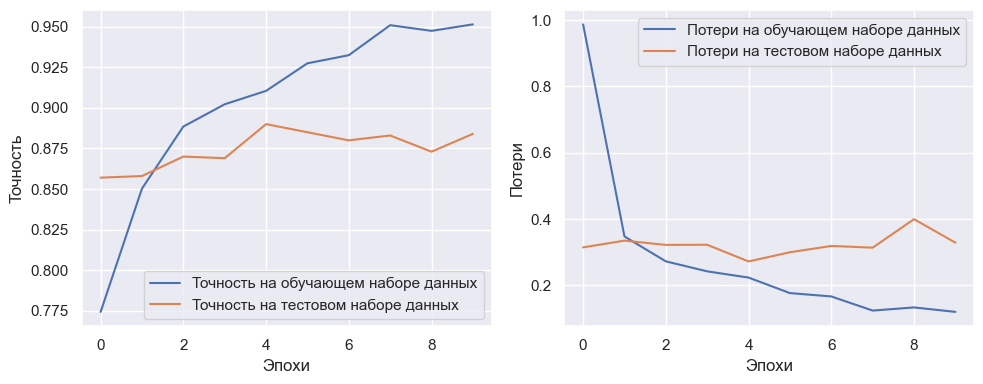

In [51]:
sns.set(font_scale = 1)

# Визуализация результатов обучения
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе данных')
plt.plot(history.history['val_accuracy'], label='Точность на тестовом наборе данных')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучающем наборе данных')
plt.plot(history.history['val_loss'], label='Потери на тестовом наборе данных')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()

Как можно заметить точность нейронной сети также достаточно высокая. 

# 3 Настройка модели и валидация

В качестве примера настройки модели рассмотрим модель 'CatBoostClassifier_100' с меньшим количеством итераций 'iteations=100'.

## 3.1 Кросс-валидация

Кросс-валидация - разбивка на k частей (в данном случае 5 частей). На четырех частях будет производится обучение модели, а последняя часть будет использоваться для тестирования. Кросс-валидация будет проходить только на тренировочных данных. Среднее значение scores представляет собой среднюю точность модели. 

In [28]:
rf = CatBoostClassifier(iterations=100, verbose=1)

scores = cross_val_score(rf, X1_train, y1_train, cv=5)


Learning rate set to 0.139841
0:	learn: 0.6343675	total: 2.81s	remaining: 4m 38s
1:	learn: 0.5863835	total: 4.47s	remaining: 3m 39s
2:	learn: 0.5458949	total: 5.76s	remaining: 3m 6s
3:	learn: 0.5160129	total: 7.07s	remaining: 2m 49s
4:	learn: 0.4925581	total: 8.41s	remaining: 2m 39s
5:	learn: 0.4705653	total: 9.65s	remaining: 2m 31s
6:	learn: 0.4536337	total: 11s	remaining: 2m 25s
7:	learn: 0.4387965	total: 12.2s	remaining: 2m 20s
8:	learn: 0.4224174	total: 13.5s	remaining: 2m 16s
9:	learn: 0.4090775	total: 14.8s	remaining: 2m 13s
10:	learn: 0.3992025	total: 16.1s	remaining: 2m 10s
11:	learn: 0.3885247	total: 17.5s	remaining: 2m 8s
12:	learn: 0.3789373	total: 18.7s	remaining: 2m 5s
13:	learn: 0.3721905	total: 20s	remaining: 2m 2s
14:	learn: 0.3643743	total: 21.3s	remaining: 2m
15:	learn: 0.3587197	total: 22.6s	remaining: 1m 58s
16:	learn: 0.3511152	total: 23.9s	remaining: 1m 56s
17:	learn: 0.3459510	total: 25.2s	remaining: 1m 54s
18:	learn: 0.3379819	total: 26.4s	remaining: 1m 52s
19:	

59:	learn: 0.1919830	total: 1m 11s	remaining: 47.4s
60:	learn: 0.1885947	total: 1m 12s	remaining: 46.2s
61:	learn: 0.1837234	total: 1m 13s	remaining: 45s
62:	learn: 0.1802529	total: 1m 14s	remaining: 43.8s
63:	learn: 0.1780367	total: 1m 15s	remaining: 42.6s
64:	learn: 0.1763612	total: 1m 16s	remaining: 41.4s
65:	learn: 0.1730998	total: 1m 18s	remaining: 40.2s
66:	learn: 0.1709919	total: 1m 19s	remaining: 39s
67:	learn: 0.1679942	total: 1m 20s	remaining: 37.8s
68:	learn: 0.1665022	total: 1m 21s	remaining: 36.6s
69:	learn: 0.1646712	total: 1m 22s	remaining: 35.4s
70:	learn: 0.1615265	total: 1m 23s	remaining: 34.2s
71:	learn: 0.1585653	total: 1m 24s	remaining: 33s
72:	learn: 0.1568010	total: 1m 26s	remaining: 31.8s
73:	learn: 0.1546979	total: 1m 27s	remaining: 30.7s
74:	learn: 0.1514590	total: 1m 28s	remaining: 29.5s
75:	learn: 0.1492967	total: 1m 29s	remaining: 28.3s
76:	learn: 0.1468683	total: 1m 30s	remaining: 27.1s
77:	learn: 0.1427509	total: 1m 32s	remaining: 26s
78:	learn: 0.1400226

17:	learn: 0.3375016	total: 21.8s	remaining: 1m 39s
18:	learn: 0.3300563	total: 22.9s	remaining: 1m 37s
19:	learn: 0.3259167	total: 24.1s	remaining: 1m 36s
20:	learn: 0.3196472	total: 25.6s	remaining: 1m 36s
21:	learn: 0.3156127	total: 26.8s	remaining: 1m 35s
22:	learn: 0.3110565	total: 28s	remaining: 1m 33s
23:	learn: 0.3052748	total: 29.1s	remaining: 1m 32s
24:	learn: 0.3004406	total: 30.3s	remaining: 1m 31s
25:	learn: 0.2975205	total: 31.5s	remaining: 1m 29s
26:	learn: 0.2928240	total: 32.7s	remaining: 1m 28s
27:	learn: 0.2885866	total: 34.2s	remaining: 1m 28s
28:	learn: 0.2851361	total: 35.4s	remaining: 1m 26s
29:	learn: 0.2816266	total: 36.5s	remaining: 1m 25s
30:	learn: 0.2776928	total: 37.7s	remaining: 1m 23s
31:	learn: 0.2735239	total: 38.9s	remaining: 1m 22s
32:	learn: 0.2702473	total: 40.2s	remaining: 1m 21s
33:	learn: 0.2670732	total: 41.3s	remaining: 1m 20s
34:	learn: 0.2643107	total: 42.7s	remaining: 1m 19s
35:	learn: 0.2610968	total: 43.9s	remaining: 1m 18s
36:	learn: 0.2

76:	learn: 0.1377116	total: 1m 37s	remaining: 29.1s
77:	learn: 0.1358550	total: 1m 38s	remaining: 27.9s
78:	learn: 0.1348503	total: 1m 40s	remaining: 26.7s
79:	learn: 0.1322921	total: 1m 41s	remaining: 25.4s
80:	learn: 0.1301453	total: 1m 43s	remaining: 24.2s
81:	learn: 0.1273797	total: 1m 44s	remaining: 22.9s
82:	learn: 0.1251682	total: 1m 45s	remaining: 21.6s
83:	learn: 0.1221097	total: 1m 46s	remaining: 20.3s
84:	learn: 0.1203737	total: 1m 48s	remaining: 19.1s
85:	learn: 0.1189270	total: 1m 49s	remaining: 17.8s
86:	learn: 0.1170076	total: 1m 50s	remaining: 16.5s
87:	learn: 0.1161221	total: 1m 52s	remaining: 15.3s
88:	learn: 0.1147391	total: 1m 53s	remaining: 14s
89:	learn: 0.1128468	total: 1m 54s	remaining: 12.7s
90:	learn: 0.1113778	total: 1m 55s	remaining: 11.5s
91:	learn: 0.1091159	total: 1m 57s	remaining: 10.2s
92:	learn: 0.1069740	total: 1m 58s	remaining: 8.91s
93:	learn: 0.1048885	total: 1m 59s	remaining: 7.64s
94:	learn: 0.1033739	total: 2m	remaining: 6.36s
95:	learn: 0.10190

In [29]:
scores

array([0.8625 , 0.84375, 0.8625 , 0.85625, 0.8525 ])

## 3.2 Настройка гиперпараметров

Определим основные гиперпараметры для модели **CatBoostClassifier** и **default** гиперпараметры.  
- iterations: 1000 (в нашем случае принято **100**),
- learning_rate: **0.03**,
- l2_leaf_reg: **3**,
- bagging_temperature: **1**,
- subsample: **0.66**,
- random_strength: **1**,
- depth: **6**,
- rsm: **1**,
- one_hot_max_size: **2**
- leaf_estimation_method: **’Gradient’**,
- fold_len_multiplier: **2**,
- border_count: **128**.

Можно выделить три основных метода настройки гиперпараметров:   
1) Ручной, путем добавления к модели;  
2) Поиск по сетке, при помощи GridSearchCV.  
3) Случайный поиск, при помощи RandomizedSearchCV.

In [313]:
# Применим поиск по сетке с использованием метода GridSearchCV.

rf = CatBoostClassifier(iterations=100, verbose=1)

# Определяем гиперпараметры для CatBoost модели
hyperparams = {
    'iterations': [90, 100, 110],         #максимальное количество деревьев 
    'depth': [4, 6, 8],                   #глубина каждого дерева
    'learning_rate': [0.02, 0.03, 0.04]   #скорость обучения
}

cross_val = GridSearchCV(rf, hyperparams, cv=5)
cross_val.fit(X1_train, y1_train.ravel())

0:	learn: 0.6846635	total: 675ms	remaining: 1m
1:	learn: 0.6770470	total: 1.1s	remaining: 48.5s
2:	learn: 0.6691513	total: 1.52s	remaining: 44s
3:	learn: 0.6618161	total: 1.94s	remaining: 41.6s
4:	learn: 0.6551157	total: 2.36s	remaining: 40.1s
5:	learn: 0.6482993	total: 2.79s	remaining: 39.1s
6:	learn: 0.6411285	total: 3.23s	remaining: 38.3s
7:	learn: 0.6351305	total: 3.67s	remaining: 37.6s
8:	learn: 0.6295103	total: 4.08s	remaining: 36.7s
9:	learn: 0.6237423	total: 4.51s	remaining: 36.1s
10:	learn: 0.6182888	total: 4.96s	remaining: 35.6s
11:	learn: 0.6122295	total: 5.48s	remaining: 35.6s
12:	learn: 0.6067097	total: 5.89s	remaining: 34.9s
13:	learn: 0.6014070	total: 6.31s	remaining: 34.2s
14:	learn: 0.5961452	total: 6.74s	remaining: 33.7s
15:	learn: 0.5907907	total: 7.16s	remaining: 33.1s
16:	learn: 0.5855312	total: 7.58s	remaining: 32.6s
17:	learn: 0.5809613	total: 8.02s	remaining: 32.1s
18:	learn: 0.5770713	total: 8.44s	remaining: 31.5s
19:	learn: 0.5718026	total: 8.85s	remaining: 31

73:	learn: 0.4364424	total: 36.5s	remaining: 7.89s
74:	learn: 0.4349857	total: 37.2s	remaining: 7.45s
75:	learn: 0.4334751	total: 38.4s	remaining: 7.07s
76:	learn: 0.4320943	total: 39s	remaining: 6.59s
77:	learn: 0.4306099	total: 39.6s	remaining: 6.09s
78:	learn: 0.4295154	total: 40.3s	remaining: 5.62s
79:	learn: 0.4283511	total: 41.3s	remaining: 5.16s
80:	learn: 0.4268061	total: 42.2s	remaining: 4.69s
81:	learn: 0.4257332	total: 42.8s	remaining: 4.17s
82:	learn: 0.4248615	total: 43.4s	remaining: 3.66s
83:	learn: 0.4236698	total: 43.8s	remaining: 3.13s
84:	learn: 0.4223835	total: 44.3s	remaining: 2.61s
85:	learn: 0.4213128	total: 44.8s	remaining: 2.08s
86:	learn: 0.4199013	total: 45.2s	remaining: 1.56s
87:	learn: 0.4188660	total: 45.7s	remaining: 1.04s
88:	learn: 0.4178525	total: 46.2s	remaining: 519ms
89:	learn: 0.4165914	total: 46.7s	remaining: 0us
0:	learn: 0.6850320	total: 472ms	remaining: 42s
1:	learn: 0.6758669	total: 960ms	remaining: 42.2s
2:	learn: 0.6675565	total: 1.44s	remain

56:	learn: 0.4633780	total: 34.4s	remaining: 19.9s
57:	learn: 0.4619252	total: 34.8s	remaining: 19.2s
58:	learn: 0.4602928	total: 35.3s	remaining: 18.6s
59:	learn: 0.4588136	total: 36s	remaining: 18s
60:	learn: 0.4567093	total: 36.7s	remaining: 17.4s
61:	learn: 0.4548401	total: 37.4s	remaining: 16.9s
62:	learn: 0.4535933	total: 37.9s	remaining: 16.2s
63:	learn: 0.4515469	total: 38.5s	remaining: 15.6s
64:	learn: 0.4498007	total: 39.2s	remaining: 15.1s
65:	learn: 0.4482658	total: 39.7s	remaining: 14.4s
66:	learn: 0.4466993	total: 40.2s	remaining: 13.8s
67:	learn: 0.4451925	total: 41.3s	remaining: 13.4s
68:	learn: 0.4440491	total: 41.8s	remaining: 12.7s
69:	learn: 0.4426059	total: 42.3s	remaining: 12.1s
70:	learn: 0.4410073	total: 42.9s	remaining: 11.5s
71:	learn: 0.4396289	total: 43.4s	remaining: 10.8s
72:	learn: 0.4382236	total: 43.9s	remaining: 10.2s
73:	learn: 0.4368419	total: 44.8s	remaining: 9.68s
74:	learn: 0.4353702	total: 45.4s	remaining: 9.07s
75:	learn: 0.4340789	total: 46.4s	r

39:	learn: 0.4619325	total: 22.1s	remaining: 27.6s
40:	learn: 0.4598667	total: 23s	remaining: 27.5s
41:	learn: 0.4574822	total: 23.5s	remaining: 26.9s
42:	learn: 0.4550575	total: 24s	remaining: 26.2s
43:	learn: 0.4526598	total: 24.5s	remaining: 25.6s
44:	learn: 0.4506914	total: 25s	remaining: 25s
45:	learn: 0.4486555	total: 25.8s	remaining: 24.7s
46:	learn: 0.4467920	total: 26.3s	remaining: 24.1s
47:	learn: 0.4446845	total: 27.2s	remaining: 23.8s
48:	learn: 0.4422401	total: 28.1s	remaining: 23.5s
49:	learn: 0.4401024	total: 29.1s	remaining: 23.3s
50:	learn: 0.4381872	total: 30s	remaining: 22.9s
51:	learn: 0.4362322	total: 30.9s	remaining: 22.6s
52:	learn: 0.4340521	total: 31.9s	remaining: 22.3s
53:	learn: 0.4326107	total: 32.9s	remaining: 21.9s
54:	learn: 0.4303946	total: 33.9s	remaining: 21.6s
55:	learn: 0.4283664	total: 34.9s	remaining: 21.2s
56:	learn: 0.4264960	total: 35.9s	remaining: 20.8s
57:	learn: 0.4245858	total: 36.9s	remaining: 20.4s
58:	learn: 0.4224191	total: 37.8s	remaini

22:	learn: 0.5169141	total: 13s	remaining: 37.7s
23:	learn: 0.5121542	total: 13.5s	remaining: 37.1s
24:	learn: 0.5074392	total: 14s	remaining: 36.5s
25:	learn: 0.5037476	total: 14.9s	remaining: 36.8s
26:	learn: 0.4999631	total: 15.9s	remaining: 37.1s
27:	learn: 0.4966500	total: 16.9s	remaining: 37.4s
28:	learn: 0.4934275	total: 17.8s	remaining: 37.5s
29:	learn: 0.4896326	total: 18.9s	remaining: 37.9s
30:	learn: 0.4862281	total: 19.9s	remaining: 37.8s
31:	learn: 0.4834831	total: 20.9s	remaining: 37.8s
32:	learn: 0.4804755	total: 21.8s	remaining: 37.7s
33:	learn: 0.4774223	total: 22.8s	remaining: 37.6s
34:	learn: 0.4746208	total: 23.9s	remaining: 37.6s
35:	learn: 0.4719746	total: 24.9s	remaining: 37.3s
36:	learn: 0.4680593	total: 25.9s	remaining: 37s
37:	learn: 0.4658027	total: 26.8s	remaining: 36.7s
38:	learn: 0.4634606	total: 27.3s	remaining: 35.7s
39:	learn: 0.4609478	total: 27.7s	remaining: 34.6s
40:	learn: 0.4583660	total: 28.1s	remaining: 33.6s
41:	learn: 0.4559082	total: 28.6s	rem

5:	learn: 0.6264206	total: 3.7s	remaining: 51.8s
6:	learn: 0.6164085	total: 4.18s	remaining: 49.5s
7:	learn: 0.6085906	total: 4.68s	remaining: 48s
8:	learn: 0.6003500	total: 5.29s	remaining: 47.6s
9:	learn: 0.5924832	total: 5.8s	remaining: 46.4s
10:	learn: 0.5839034	total: 6.37s	remaining: 45.7s
11:	learn: 0.5765117	total: 6.91s	remaining: 44.9s
12:	learn: 0.5698849	total: 7.54s	remaining: 44.7s
13:	learn: 0.5630241	total: 8.53s	remaining: 46.3s
14:	learn: 0.5566968	total: 9.13s	remaining: 45.7s
15:	learn: 0.5500066	total: 9.68s	remaining: 44.8s
16:	learn: 0.5442154	total: 10.2s	remaining: 43.9s
17:	learn: 0.5381316	total: 10.7s	remaining: 43s
18:	learn: 0.5334877	total: 11.3s	remaining: 42.2s
19:	learn: 0.5283666	total: 12.1s	remaining: 42.3s
20:	learn: 0.5235996	total: 12.6s	remaining: 41.5s
21:	learn: 0.5187409	total: 13.2s	remaining: 40.7s
22:	learn: 0.5139597	total: 13.7s	remaining: 39.8s
23:	learn: 0.5101590	total: 14.2s	remaining: 38.9s
24:	learn: 0.5061575	total: 14.8s	remainin

77:	learn: 0.3677728	total: 46.2s	remaining: 7.1s
78:	learn: 0.3664613	total: 46.6s	remaining: 6.49s
79:	learn: 0.3653684	total: 47.1s	remaining: 5.89s
80:	learn: 0.3640786	total: 47.6s	remaining: 5.29s
81:	learn: 0.3628853	total: 48.4s	remaining: 4.72s
82:	learn: 0.3617989	total: 48.8s	remaining: 4.12s
83:	learn: 0.3603885	total: 49.3s	remaining: 3.52s
84:	learn: 0.3595042	total: 49.9s	remaining: 2.94s
85:	learn: 0.3580749	total: 50.5s	remaining: 2.35s
86:	learn: 0.3568587	total: 51.1s	remaining: 1.76s
87:	learn: 0.3559759	total: 51.8s	remaining: 1.18s
88:	learn: 0.3548317	total: 52.3s	remaining: 587ms
89:	learn: 0.3536919	total: 52.8s	remaining: 0us
0:	learn: 0.6765169	total: 707ms	remaining: 1m 2s
1:	learn: 0.6613861	total: 1.7s	remaining: 1m 14s
2:	learn: 0.6464031	total: 2.73s	remaining: 1m 19s
3:	learn: 0.6345882	total: 3.71s	remaining: 1m 19s
4:	learn: 0.6216433	total: 4.71s	remaining: 1m 20s
5:	learn: 0.6086974	total: 5.7s	remaining: 1m 19s
6:	learn: 0.5980135	total: 6.67s	rema

59:	learn: 0.3909399	total: 38.3s	remaining: 19.2s
60:	learn: 0.3896720	total: 38.9s	remaining: 18.5s
61:	learn: 0.3883992	total: 39.4s	remaining: 17.8s
62:	learn: 0.3864361	total: 39.9s	remaining: 17.1s
63:	learn: 0.3849696	total: 40.3s	remaining: 16.4s
64:	learn: 0.3837032	total: 41s	remaining: 15.8s
65:	learn: 0.3827230	total: 41.7s	remaining: 15.2s
66:	learn: 0.3812671	total: 42.3s	remaining: 14.5s
67:	learn: 0.3803342	total: 42.8s	remaining: 13.9s
68:	learn: 0.3792068	total: 43.3s	remaining: 13.2s
69:	learn: 0.3782326	total: 43.9s	remaining: 12.5s
70:	learn: 0.3770471	total: 44.4s	remaining: 11.9s
71:	learn: 0.3762932	total: 44.9s	remaining: 11.2s
72:	learn: 0.3752745	total: 45.7s	remaining: 10.6s
73:	learn: 0.3741300	total: 46.5s	remaining: 10s
74:	learn: 0.3730729	total: 46.9s	remaining: 9.38s
75:	learn: 0.3720179	total: 47.4s	remaining: 8.74s
76:	learn: 0.3707909	total: 48s	remaining: 8.1s
77:	learn: 0.3695163	total: 48.5s	remaining: 7.46s
78:	learn: 0.3683429	total: 49.2s	rema

42:	learn: 0.4207179	total: 22.5s	remaining: 24.6s
43:	learn: 0.4181548	total: 23.1s	remaining: 24.1s
44:	learn: 0.4159291	total: 23.6s	remaining: 23.6s
45:	learn: 0.4135927	total: 24.1s	remaining: 23s
46:	learn: 0.4115657	total: 24.7s	remaining: 22.6s
47:	learn: 0.4097841	total: 25.2s	remaining: 22s
48:	learn: 0.4079675	total: 26.1s	remaining: 21.8s
49:	learn: 0.4058778	total: 26.5s	remaining: 21.2s
50:	learn: 0.4041793	total: 27.1s	remaining: 20.7s
51:	learn: 0.4022989	total: 28s	remaining: 20.4s
52:	learn: 0.4006725	total: 28.6s	remaining: 19.9s
53:	learn: 0.3993264	total: 29.1s	remaining: 19.4s
54:	learn: 0.3975969	total: 29.6s	remaining: 18.8s
55:	learn: 0.3960734	total: 30.4s	remaining: 18.5s
56:	learn: 0.3948500	total: 30.9s	remaining: 17.9s
57:	learn: 0.3931310	total: 31.4s	remaining: 17.3s
58:	learn: 0.3917383	total: 31.9s	remaining: 16.8s
59:	learn: 0.3905246	total: 32.9s	remaining: 16.4s
60:	learn: 0.3891646	total: 33.8s	remaining: 16.1s
61:	learn: 0.3870411	total: 34.8s	rem

14:	learn: 0.5929597	total: 9.06s	remaining: 51.3s
15:	learn: 0.5877592	total: 10s	remaining: 52.6s
16:	learn: 0.5830588	total: 11s	remaining: 53.5s
17:	learn: 0.5776745	total: 11.9s	remaining: 54.2s
18:	learn: 0.5733065	total: 12.8s	remaining: 54.6s
19:	learn: 0.5688245	total: 13.8s	remaining: 55.4s
20:	learn: 0.5647119	total: 14.8s	remaining: 55.8s
21:	learn: 0.5608723	total: 15.8s	remaining: 55.9s
22:	learn: 0.5564962	total: 16.7s	remaining: 56s
23:	learn: 0.5522949	total: 17.6s	remaining: 55.7s
24:	learn: 0.5488501	total: 18.5s	remaining: 55.5s
25:	learn: 0.5447775	total: 19.5s	remaining: 55.5s
26:	learn: 0.5413225	total: 20.2s	remaining: 54.7s
27:	learn: 0.5378286	total: 20.7s	remaining: 53.1s
28:	learn: 0.5341900	total: 21.1s	remaining: 51.7s
29:	learn: 0.5305462	total: 21.6s	remaining: 50.4s
30:	learn: 0.5266129	total: 22s	remaining: 49.1s
31:	learn: 0.5234080	total: 22.5s	remaining: 47.8s
32:	learn: 0.5205399	total: 23s	remaining: 46.6s
33:	learn: 0.5176297	total: 23.4s	remaini

77:	learn: 0.4350333	total: 49.7s	remaining: 14s
78:	learn: 0.4336885	total: 50.2s	remaining: 13.3s
79:	learn: 0.4325095	total: 50.7s	remaining: 12.7s
80:	learn: 0.4313296	total: 51.2s	remaining: 12s
81:	learn: 0.4300788	total: 51.7s	remaining: 11.3s
82:	learn: 0.4290982	total: 52.1s	remaining: 10.7s
83:	learn: 0.4279469	total: 52.6s	remaining: 10s
84:	learn: 0.4271696	total: 53.6s	remaining: 9.45s
85:	learn: 0.4260929	total: 54.1s	remaining: 8.8s
86:	learn: 0.4250906	total: 54.5s	remaining: 8.15s
87:	learn: 0.4242624	total: 55.1s	remaining: 7.51s
88:	learn: 0.4231926	total: 55.6s	remaining: 6.87s
89:	learn: 0.4217968	total: 56.1s	remaining: 6.23s
90:	learn: 0.4203837	total: 56.5s	remaining: 5.59s
91:	learn: 0.4193860	total: 57s	remaining: 4.96s
92:	learn: 0.4180853	total: 57.8s	remaining: 4.35s
93:	learn: 0.4168093	total: 58.3s	remaining: 3.72s
94:	learn: 0.4157683	total: 58.7s	remaining: 3.09s
95:	learn: 0.4147906	total: 59.2s	remaining: 2.47s
96:	learn: 0.4136576	total: 59.9s	remain

40:	learn: 0.4968168	total: 23.9s	remaining: 34.5s
41:	learn: 0.4943900	total: 24.9s	remaining: 34.4s
42:	learn: 0.4920340	total: 25.9s	remaining: 34.4s
43:	learn: 0.4895199	total: 26.9s	remaining: 34.2s
44:	learn: 0.4872370	total: 27.9s	remaining: 34.1s
45:	learn: 0.4851855	total: 28.8s	remaining: 33.9s
46:	learn: 0.4830965	total: 29.7s	remaining: 33.5s
47:	learn: 0.4807979	total: 30.7s	remaining: 33.3s
48:	learn: 0.4784525	total: 31.7s	remaining: 33s
49:	learn: 0.4758309	total: 32.8s	remaining: 32.8s
50:	learn: 0.4736115	total: 33.4s	remaining: 32s
51:	learn: 0.4717143	total: 33.8s	remaining: 31.2s
52:	learn: 0.4696042	total: 34.3s	remaining: 30.4s
53:	learn: 0.4675909	total: 34.8s	remaining: 29.7s
54:	learn: 0.4655555	total: 35.3s	remaining: 28.9s
55:	learn: 0.4636480	total: 35.8s	remaining: 28.1s
56:	learn: 0.4617904	total: 36.3s	remaining: 27.4s
57:	learn: 0.4600230	total: 36.7s	remaining: 26.6s
58:	learn: 0.4583995	total: 37.2s	remaining: 25.9s
59:	learn: 0.4562223	total: 37.7s	r

2:	learn: 0.6568102	total: 1.61s	remaining: 52s
3:	learn: 0.6459981	total: 2.17s	remaining: 52s
4:	learn: 0.6360132	total: 2.69s	remaining: 51.2s
5:	learn: 0.6276887	total: 3.46s	remaining: 54.3s
6:	learn: 0.6185675	total: 3.98s	remaining: 52.9s
7:	learn: 0.6089537	total: 4.5s	remaining: 51.7s
8:	learn: 0.6024771	total: 4.98s	remaining: 50.4s
9:	learn: 0.5948769	total: 5.47s	remaining: 49.2s
10:	learn: 0.5873991	total: 5.94s	remaining: 48.1s
11:	learn: 0.5798874	total: 6.43s	remaining: 47.2s
12:	learn: 0.5729561	total: 6.91s	remaining: 46.3s
13:	learn: 0.5660299	total: 7.41s	remaining: 45.5s
14:	learn: 0.5597377	total: 7.94s	remaining: 45s
15:	learn: 0.5539229	total: 8.58s	remaining: 45s
16:	learn: 0.5477964	total: 9.31s	remaining: 45.5s
17:	learn: 0.5418537	total: 9.84s	remaining: 44.8s
18:	learn: 0.5368404	total: 10.7s	remaining: 45.4s
19:	learn: 0.5320121	total: 11.1s	remaining: 44.3s
20:	learn: 0.5276089	total: 11.7s	remaining: 44s
21:	learn: 0.5226943	total: 12.6s	remaining: 44.7s

65:	learn: 0.4112590	total: 40.8s	remaining: 21s
66:	learn: 0.4098070	total: 41.2s	remaining: 20.3s
67:	learn: 0.4086179	total: 41.7s	remaining: 19.6s
68:	learn: 0.4071536	total: 42.3s	remaining: 19s
69:	learn: 0.4058764	total: 42.9s	remaining: 18.4s
70:	learn: 0.4044867	total: 43.4s	remaining: 17.7s
71:	learn: 0.4033792	total: 43.8s	remaining: 17.1s
72:	learn: 0.4023301	total: 44.3s	remaining: 16.4s
73:	learn: 0.4010140	total: 44.8s	remaining: 15.7s
74:	learn: 0.3999391	total: 45.3s	remaining: 15.1s
75:	learn: 0.3983937	total: 45.8s	remaining: 14.5s
76:	learn: 0.3972937	total: 46.7s	remaining: 14s
77:	learn: 0.3960975	total: 47.2s	remaining: 13.3s
78:	learn: 0.3947995	total: 47.7s	remaining: 12.7s
79:	learn: 0.3937751	total: 48.2s	remaining: 12s
80:	learn: 0.3926423	total: 48.8s	remaining: 11.4s
81:	learn: 0.3914137	total: 49.3s	remaining: 10.8s
82:	learn: 0.3905602	total: 49.8s	remaining: 10.2s
83:	learn: 0.3895972	total: 50.3s	remaining: 9.58s
84:	learn: 0.3883350	total: 50.9s	remai

28:	learn: 0.4910826	total: 14.9s	remaining: 36.4s
29:	learn: 0.4874191	total: 15.3s	remaining: 35.7s
30:	learn: 0.4838471	total: 15.9s	remaining: 35.4s
31:	learn: 0.4806147	total: 16.4s	remaining: 34.9s
32:	learn: 0.4775327	total: 17.2s	remaining: 34.9s
33:	learn: 0.4742099	total: 18.1s	remaining: 35.1s
34:	learn: 0.4710555	total: 18.9s	remaining: 35.2s
35:	learn: 0.4678351	total: 19.8s	remaining: 35.2s
36:	learn: 0.4648363	total: 20.6s	remaining: 35.1s
37:	learn: 0.4617164	total: 21.5s	remaining: 35.1s
38:	learn: 0.4592562	total: 22.5s	remaining: 35.1s
39:	learn: 0.4566360	total: 23.4s	remaining: 35s
40:	learn: 0.4540359	total: 24.3s	remaining: 35s
41:	learn: 0.4517896	total: 25.2s	remaining: 34.9s
42:	learn: 0.4492260	total: 26.1s	remaining: 34.6s
43:	learn: 0.4470556	total: 26.9s	remaining: 34.3s
44:	learn: 0.4449662	total: 27.8s	remaining: 34s
45:	learn: 0.4425688	total: 28.6s	remaining: 33.6s
46:	learn: 0.4405342	total: 29.1s	remaining: 32.8s
47:	learn: 0.4383681	total: 29.5s	rem

91:	learn: 0.3518147	total: 1m	remaining: 5.28s
92:	learn: 0.3507885	total: 1m 1s	remaining: 4.61s
93:	learn: 0.3500792	total: 1m 1s	remaining: 3.94s
94:	learn: 0.3491343	total: 1m 2s	remaining: 3.29s
95:	learn: 0.3483387	total: 1m 3s	remaining: 2.63s
96:	learn: 0.3473373	total: 1m 3s	remaining: 1.97s
97:	learn: 0.3466345	total: 1m 4s	remaining: 1.32s
98:	learn: 0.3456322	total: 1m 5s	remaining: 659ms
99:	learn: 0.3447409	total: 1m 5s	remaining: 0us
0:	learn: 0.6765169	total: 1.12s	remaining: 1m 51s
1:	learn: 0.6613861	total: 2.26s	remaining: 1m 50s
2:	learn: 0.6464031	total: 3.28s	remaining: 1m 45s
3:	learn: 0.6345882	total: 4.31s	remaining: 1m 43s
4:	learn: 0.6216433	total: 5.33s	remaining: 1m 41s
5:	learn: 0.6086974	total: 5.8s	remaining: 1m 30s
6:	learn: 0.5980135	total: 6.34s	remaining: 1m 24s
7:	learn: 0.5884270	total: 6.82s	remaining: 1m 18s
8:	learn: 0.5794859	total: 7.34s	remaining: 1m 14s
9:	learn: 0.5703210	total: 7.93s	remaining: 1m 11s
10:	learn: 0.5617566	total: 8.38s	rem

54:	learn: 0.3988092	total: 33.6s	remaining: 27.5s
55:	learn: 0.3971991	total: 34s	remaining: 26.7s
56:	learn: 0.3950135	total: 34.5s	remaining: 26s
57:	learn: 0.3934553	total: 34.9s	remaining: 25.3s
58:	learn: 0.3924259	total: 35.5s	remaining: 24.6s
59:	learn: 0.3909399	total: 35.9s	remaining: 24s
60:	learn: 0.3896720	total: 36.4s	remaining: 23.3s
61:	learn: 0.3883992	total: 36.9s	remaining: 22.6s
62:	learn: 0.3864361	total: 37.4s	remaining: 22s
63:	learn: 0.3849696	total: 37.9s	remaining: 21.3s
64:	learn: 0.3837032	total: 38.4s	remaining: 20.7s
65:	learn: 0.3827230	total: 39.1s	remaining: 20.2s
66:	learn: 0.3812671	total: 39.7s	remaining: 19.5s
67:	learn: 0.3803342	total: 40.1s	remaining: 18.9s
68:	learn: 0.3792068	total: 40.6s	remaining: 18.2s
69:	learn: 0.3782326	total: 41.1s	remaining: 17.6s
70:	learn: 0.3770471	total: 41.6s	remaining: 17s
71:	learn: 0.3762932	total: 42.1s	remaining: 16.4s
72:	learn: 0.3752745	total: 42.8s	remaining: 15.8s
73:	learn: 0.3741300	total: 43.4s	remaini

17:	learn: 0.5071515	total: 11.9s	remaining: 54s
18:	learn: 0.5018708	total: 12.3s	remaining: 52.6s
19:	learn: 0.4975003	total: 12.8s	remaining: 51.3s
20:	learn: 0.4927279	total: 13.3s	remaining: 50s
21:	learn: 0.4883968	total: 13.8s	remaining: 48.8s
22:	learn: 0.4825114	total: 14.2s	remaining: 47.6s
23:	learn: 0.4782792	total: 14.7s	remaining: 46.5s
24:	learn: 0.4742956	total: 15.1s	remaining: 45.4s
25:	learn: 0.4705334	total: 15.6s	remaining: 44.5s
26:	learn: 0.4670575	total: 16.1s	remaining: 43.5s
27:	learn: 0.4629015	total: 16.6s	remaining: 42.6s
28:	learn: 0.4595673	total: 17.1s	remaining: 41.9s
29:	learn: 0.4565501	total: 17.6s	remaining: 41.1s
30:	learn: 0.4535068	total: 18.1s	remaining: 40.3s
31:	learn: 0.4501035	total: 18.9s	remaining: 40.1s
32:	learn: 0.4471997	total: 19.3s	remaining: 39.2s
33:	learn: 0.4442882	total: 19.8s	remaining: 38.4s
34:	learn: 0.4404156	total: 20.5s	remaining: 38.1s
35:	learn: 0.4380432	total: 21s	remaining: 37.3s
36:	learn: 0.4351651	total: 21.4s	rem

79:	learn: 0.4335612	total: 45.8s	remaining: 17.2s
80:	learn: 0.4323240	total: 46.6s	remaining: 16.7s
81:	learn: 0.4311243	total: 47.4s	remaining: 16.2s
82:	learn: 0.4298853	total: 48.3s	remaining: 15.7s
83:	learn: 0.4288805	total: 49.1s	remaining: 15.2s
84:	learn: 0.4279083	total: 50s	remaining: 14.7s
85:	learn: 0.4264541	total: 50.9s	remaining: 14.2s
86:	learn: 0.4251202	total: 51.8s	remaining: 13.7s
87:	learn: 0.4240221	total: 52.6s	remaining: 13.1s
88:	learn: 0.4227814	total: 53.5s	remaining: 12.6s
89:	learn: 0.4214190	total: 54.2s	remaining: 12s
90:	learn: 0.4201171	total: 54.6s	remaining: 11.4s
91:	learn: 0.4189238	total: 55s	remaining: 10.8s
92:	learn: 0.4178759	total: 55.4s	remaining: 10.1s
93:	learn: 0.4168615	total: 55.9s	remaining: 9.51s
94:	learn: 0.4158537	total: 56.4s	remaining: 8.9s
95:	learn: 0.4146732	total: 56.9s	remaining: 8.29s
96:	learn: 0.4136706	total: 57.3s	remaining: 7.68s
97:	learn: 0.4128482	total: 57.8s	remaining: 7.07s
98:	learn: 0.4118661	total: 58.2s	rema

21:	learn: 0.5595652	total: 11.4s	remaining: 45.4s
22:	learn: 0.5549697	total: 12.2s	remaining: 46s
23:	learn: 0.5510366	total: 13s	remaining: 46.6s
24:	learn: 0.5467612	total: 13.9s	remaining: 47.1s
25:	learn: 0.5439581	total: 14.7s	remaining: 47.6s
26:	learn: 0.5408419	total: 15.7s	remaining: 48.2s
27:	learn: 0.5377835	total: 16.5s	remaining: 48.5s
28:	learn: 0.5343243	total: 17.4s	remaining: 48.6s
29:	learn: 0.5311453	total: 18.2s	remaining: 48.7s
30:	learn: 0.5276131	total: 19.1s	remaining: 48.7s
31:	learn: 0.5244923	total: 20s	remaining: 48.7s
32:	learn: 0.5210827	total: 20.9s	remaining: 48.8s
33:	learn: 0.5177726	total: 22.2s	remaining: 49.7s
34:	learn: 0.5139425	total: 23.1s	remaining: 49.6s
35:	learn: 0.5111313	total: 23.9s	remaining: 49.2s
36:	learn: 0.5085680	total: 24.3s	remaining: 48s
37:	learn: 0.5062377	total: 24.8s	remaining: 47s
38:	learn: 0.5034782	total: 25.2s	remaining: 45.9s
39:	learn: 0.5010604	total: 25.7s	remaining: 45s
40:	learn: 0.4983340	total: 26.2s	remaining

73:	learn: 0.4368419	total: 42.7s	remaining: 20.8s
74:	learn: 0.4353702	total: 43.2s	remaining: 20.2s
75:	learn: 0.4340789	total: 43.7s	remaining: 19.6s
76:	learn: 0.4327541	total: 44.2s	remaining: 18.9s
77:	learn: 0.4315760	total: 44.6s	remaining: 18.3s
78:	learn: 0.4299726	total: 45.4s	remaining: 17.8s
79:	learn: 0.4289132	total: 45.9s	remaining: 17.2s
80:	learn: 0.4278924	total: 46.3s	remaining: 16.6s
81:	learn: 0.4269111	total: 46.8s	remaining: 16s
82:	learn: 0.4257275	total: 47.5s	remaining: 15.4s
83:	learn: 0.4245226	total: 48s	remaining: 14.8s
84:	learn: 0.4235874	total: 48.4s	remaining: 14.2s
85:	learn: 0.4224702	total: 48.9s	remaining: 13.7s
86:	learn: 0.4214038	total: 49.6s	remaining: 13.1s
87:	learn: 0.4203520	total: 50.4s	remaining: 12.6s
88:	learn: 0.4193386	total: 51.4s	remaining: 12.1s
89:	learn: 0.4180131	total: 52.4s	remaining: 11.6s
90:	learn: 0.4169740	total: 53.3s	remaining: 11.1s
91:	learn: 0.4157199	total: 54.2s	remaining: 10.6s
92:	learn: 0.4146959	total: 55.1s	r

15:	learn: 0.5548468	total: 13.8s	remaining: 1m 21s
16:	learn: 0.5498592	total: 14.4s	remaining: 1m 18s
17:	learn: 0.5447234	total: 15s	remaining: 1m 16s
18:	learn: 0.5399011	total: 15.6s	remaining: 1m 14s
19:	learn: 0.5343207	total: 16.3s	remaining: 1m 13s
20:	learn: 0.5305298	total: 17.1s	remaining: 1m 12s
21:	learn: 0.5257820	total: 18.3s	remaining: 1m 13s
22:	learn: 0.5204588	total: 19.4s	remaining: 1m 13s
23:	learn: 0.5158654	total: 20.4s	remaining: 1m 13s
24:	learn: 0.5113690	total: 21.9s	remaining: 1m 14s
25:	learn: 0.5070231	total: 22.8s	remaining: 1m 13s
26:	learn: 0.5027354	total: 24.1s	remaining: 1m 14s
27:	learn: 0.4986958	total: 25.2s	remaining: 1m 13s
28:	learn: 0.4954343	total: 26.5s	remaining: 1m 13s
29:	learn: 0.4913039	total: 27.9s	remaining: 1m 14s
30:	learn: 0.4880244	total: 29.1s	remaining: 1m 14s
31:	learn: 0.4845869	total: 30.2s	remaining: 1m 13s
32:	learn: 0.4816217	total: 31s	remaining: 1m 12s
33:	learn: 0.4782086	total: 32s	remaining: 1m 11s
34:	learn: 0.47587

66:	learn: 0.4083927	total: 45.9s	remaining: 29.5s
67:	learn: 0.4069196	total: 46.9s	remaining: 29s
68:	learn: 0.4053310	total: 47.8s	remaining: 28.4s
69:	learn: 0.4041558	total: 48.9s	remaining: 27.9s
70:	learn: 0.4024597	total: 49.8s	remaining: 27.4s
71:	learn: 0.4011534	total: 50.8s	remaining: 26.8s
72:	learn: 0.3997052	total: 51.8s	remaining: 26.3s
73:	learn: 0.3986345	total: 52.8s	remaining: 25.7s
74:	learn: 0.3970286	total: 53.7s	remaining: 25.1s
75:	learn: 0.3958205	total: 54.7s	remaining: 24.5s
76:	learn: 0.3947717	total: 55.7s	remaining: 23.9s
77:	learn: 0.3939165	total: 56.6s	remaining: 23.2s
78:	learn: 0.3924895	total: 57.3s	remaining: 22.5s
79:	learn: 0.3910003	total: 57.7s	remaining: 21.7s
80:	learn: 0.3897470	total: 58.2s	remaining: 20.8s
81:	learn: 0.3887402	total: 58.7s	remaining: 20s
82:	learn: 0.3871873	total: 59.2s	remaining: 19.3s
83:	learn: 0.3862495	total: 59.6s	remaining: 18.5s
84:	learn: 0.3854137	total: 1m	remaining: 17.7s
85:	learn: 0.3842358	total: 1m	remaini

8:	learn: 0.5989222	total: 4.83s	remaining: 54.2s
9:	learn: 0.5912151	total: 5.74s	remaining: 57.4s
10:	learn: 0.5836960	total: 6.25s	remaining: 56.3s
11:	learn: 0.5764427	total: 6.82s	remaining: 55.7s
12:	learn: 0.5695366	total: 7.35s	remaining: 54.9s
13:	learn: 0.5626068	total: 8.35s	remaining: 57.3s
14:	learn: 0.5567701	total: 9.3s	remaining: 58.9s
15:	learn: 0.5505651	total: 10.3s	remaining: 1m
16:	learn: 0.5445543	total: 11.3s	remaining: 1m 1s
17:	learn: 0.5390577	total: 12.2s	remaining: 1m 2s
18:	learn: 0.5340106	total: 13.1s	remaining: 1m 2s
19:	learn: 0.5290844	total: 14.2s	remaining: 1m 3s
20:	learn: 0.5240210	total: 15.2s	remaining: 1m 4s
21:	learn: 0.5189245	total: 16.1s	remaining: 1m 4s
22:	learn: 0.5140330	total: 17.1s	remaining: 1m 4s
23:	learn: 0.5096403	total: 18.1s	remaining: 1m 4s
24:	learn: 0.5058086	total: 19.2s	remaining: 1m 5s
25:	learn: 0.5024146	total: 19.8s	remaining: 1m 3s
26:	learn: 0.4984860	total: 20.5s	remaining: 1m 3s
27:	learn: 0.4946596	total: 21.2s	rem

60:	learn: 0.4152036	total: 42.6s	remaining: 34.2s
61:	learn: 0.4138507	total: 43.6s	remaining: 33.7s
62:	learn: 0.4123298	total: 44.1s	remaining: 32.9s
63:	learn: 0.4103394	total: 44.6s	remaining: 32s
64:	learn: 0.4089542	total: 45.1s	remaining: 31.2s
65:	learn: 0.4073176	total: 45.8s	remaining: 30.6s
66:	learn: 0.4061852	total: 46.5s	remaining: 29.8s
67:	learn: 0.4047041	total: 47s	remaining: 29s
68:	learn: 0.4033733	total: 47.5s	remaining: 28.2s
69:	learn: 0.4023858	total: 48s	remaining: 27.4s
70:	learn: 0.4010137	total: 48.5s	remaining: 26.6s
71:	learn: 0.3998056	total: 49s	remaining: 25.9s
72:	learn: 0.3988416	total: 49.5s	remaining: 25.1s
73:	learn: 0.3975578	total: 50.3s	remaining: 24.4s
74:	learn: 0.3966318	total: 50.8s	remaining: 23.7s
75:	learn: 0.3954685	total: 51.3s	remaining: 23s
76:	learn: 0.3944219	total: 51.9s	remaining: 22.2s
77:	learn: 0.3932790	total: 52.6s	remaining: 21.6s
78:	learn: 0.3921433	total: 53.2s	remaining: 20.9s
79:	learn: 0.3908942	total: 53.7s	remaining

2:	learn: 0.6464031	total: 1.53s	remaining: 54.7s
3:	learn: 0.6345882	total: 2.01s	remaining: 53.2s
4:	learn: 0.6216433	total: 2.52s	remaining: 53s
5:	learn: 0.6086974	total: 3.02s	remaining: 52.3s
6:	learn: 0.5980135	total: 3.5s	remaining: 51.5s
7:	learn: 0.5884270	total: 4s	remaining: 50.9s
8:	learn: 0.5794859	total: 4.48s	remaining: 50.3s
9:	learn: 0.5703210	total: 5.18s	remaining: 51.8s
10:	learn: 0.5617566	total: 5.67s	remaining: 51s
11:	learn: 0.5531438	total: 6.23s	remaining: 50.9s
12:	learn: 0.5465759	total: 6.71s	remaining: 50.1s
13:	learn: 0.5386932	total: 7.24s	remaining: 49.6s
14:	learn: 0.5315208	total: 7.71s	remaining: 48.8s
15:	learn: 0.5245153	total: 8.2s	remaining: 48.2s
16:	learn: 0.5178485	total: 8.84s	remaining: 48.3s
17:	learn: 0.5118180	total: 9.35s	remaining: 47.8s
18:	learn: 0.5067829	total: 9.84s	remaining: 47.1s
19:	learn: 0.5012311	total: 10.8s	remaining: 48.7s
20:	learn: 0.4955025	total: 11.4s	remaining: 48.3s
21:	learn: 0.4907259	total: 11.8s	remaining: 47.

54:	learn: 0.3988092	total: 35.3s	remaining: 35.3s
55:	learn: 0.3971991	total: 35.8s	remaining: 34.5s
56:	learn: 0.3950135	total: 36.3s	remaining: 33.8s
57:	learn: 0.3934553	total: 37.1s	remaining: 33.2s
58:	learn: 0.3924259	total: 37.6s	remaining: 32.5s
59:	learn: 0.3909399	total: 38.1s	remaining: 31.7s
60:	learn: 0.3896720	total: 38.6s	remaining: 31s
61:	learn: 0.3883992	total: 39.4s	remaining: 30.5s
62:	learn: 0.3864361	total: 40s	remaining: 29.8s
63:	learn: 0.3849696	total: 40.5s	remaining: 29.1s
64:	learn: 0.3837032	total: 41s	remaining: 28.4s
65:	learn: 0.3827230	total: 41.5s	remaining: 27.6s
66:	learn: 0.3812671	total: 42s	remaining: 27s
67:	learn: 0.3803342	total: 42.5s	remaining: 26.3s
68:	learn: 0.3792068	total: 43s	remaining: 25.6s
69:	learn: 0.3782326	total: 43.5s	remaining: 24.9s
70:	learn: 0.3770471	total: 44.1s	remaining: 24.2s
71:	learn: 0.3762932	total: 44.7s	remaining: 23.6s
72:	learn: 0.3752745	total: 45.8s	remaining: 23.2s
73:	learn: 0.3741300	total: 47s	remaining: 

106:	learn: 0.3348978	total: 1m 15s	remaining: 2.1s
107:	learn: 0.3342304	total: 1m 15s	remaining: 1.4s
108:	learn: 0.3334990	total: 1m 16s	remaining: 699ms
109:	learn: 0.3327705	total: 1m 16s	remaining: 0us
0:	learn: 0.6760383	total: 491ms	remaining: 53.5s
1:	learn: 0.6605830	total: 1.07s	remaining: 57.6s
2:	learn: 0.6452444	total: 1.81s	remaining: 1m 4s
3:	learn: 0.6321088	total: 2.27s	remaining: 1m
4:	learn: 0.6189399	total: 3.01s	remaining: 1m 3s
5:	learn: 0.6080072	total: 4.02s	remaining: 1m 9s
6:	learn: 0.5958982	total: 4.89s	remaining: 1m 11s
7:	learn: 0.5853145	total: 5.79s	remaining: 1m 13s
8:	learn: 0.5756963	total: 6.68s	remaining: 1m 14s
9:	learn: 0.5661289	total: 7.59s	remaining: 1m 15s
10:	learn: 0.5569495	total: 8.45s	remaining: 1m 16s
11:	learn: 0.5488625	total: 9.33s	remaining: 1m 16s
12:	learn: 0.5416888	total: 10.3s	remaining: 1m 17s
13:	learn: 0.5334629	total: 11.2s	remaining: 1m 16s
14:	learn: 0.5266689	total: 12.1s	remaining: 1m 16s
15:	learn: 0.5194569	total: 13s

47:	learn: 0.4445300	total: 1m 25s	remaining: 1m 14s
48:	learn: 0.4422513	total: 1m 28s	remaining: 1m 13s
49:	learn: 0.4402206	total: 1m 30s	remaining: 1m 12s
50:	learn: 0.4380671	total: 1m 33s	remaining: 1m 11s
51:	learn: 0.4356702	total: 1m 35s	remaining: 1m 10s
52:	learn: 0.4334087	total: 1m 37s	remaining: 1m 8s
53:	learn: 0.4306586	total: 1m 39s	remaining: 1m 6s
54:	learn: 0.4285274	total: 1m 40s	remaining: 1m 4s
55:	learn: 0.4265986	total: 1m 42s	remaining: 1m 2s
56:	learn: 0.4238467	total: 1m 44s	remaining: 1m
57:	learn: 0.4221885	total: 1m 45s	remaining: 58.3s
58:	learn: 0.4203812	total: 1m 47s	remaining: 56.3s
59:	learn: 0.4182902	total: 1m 48s	remaining: 54.4s
60:	learn: 0.4166713	total: 1m 50s	remaining: 52.4s
61:	learn: 0.4143642	total: 1m 51s	remaining: 50.5s
62:	learn: 0.4124505	total: 1m 53s	remaining: 48.6s
63:	learn: 0.4104161	total: 1m 54s	remaining: 46.6s
64:	learn: 0.4085760	total: 1m 56s	remaining: 44.7s
65:	learn: 0.4069799	total: 1m 57s	remaining: 42.8s
66:	learn:

26:	learn: 0.5121495	total: 51.8s	remaining: 2m
27:	learn: 0.5082681	total: 53.3s	remaining: 1m 57s
28:	learn: 0.5034247	total: 54.8s	remaining: 1m 55s
29:	learn: 0.4998232	total: 56.5s	remaining: 1m 52s
30:	learn: 0.4962711	total: 58s	remaining: 1m 50s
31:	learn: 0.4921672	total: 1m	remaining: 1m 49s
32:	learn: 0.4892331	total: 1m 2s	remaining: 1m 48s
33:	learn: 0.4860213	total: 1m 5s	remaining: 1m 47s
34:	learn: 0.4825086	total: 1m 7s	remaining: 1m 46s
35:	learn: 0.4798290	total: 1m 10s	remaining: 1m 45s
36:	learn: 0.4763977	total: 1m 12s	remaining: 1m 43s
37:	learn: 0.4733078	total: 1m 13s	remaining: 1m 40s
38:	learn: 0.4696701	total: 1m 15s	remaining: 1m 38s
39:	learn: 0.4662359	total: 1m 16s	remaining: 1m 35s
40:	learn: 0.4628831	total: 1m 17s	remaining: 1m 33s
41:	learn: 0.4605754	total: 1m 19s	remaining: 1m 30s
42:	learn: 0.4579478	total: 1m 21s	remaining: 1m 28s
43:	learn: 0.4556973	total: 1m 22s	remaining: 1m 26s
44:	learn: 0.4531492	total: 1m 24s	remaining: 1m 24s
45:	learn: 

5:	learn: 0.6381803	total: 9.74s	remaining: 2m 16s
6:	learn: 0.6304787	total: 12.3s	remaining: 2m 25s
7:	learn: 0.6223801	total: 14.9s	remaining: 2m 32s
8:	learn: 0.6149474	total: 17.4s	remaining: 2m 36s
9:	learn: 0.6080975	total: 20.1s	remaining: 2m 41s
10:	learn: 0.6011423	total: 22s	remaining: 2m 37s
11:	learn: 0.5945510	total: 23.6s	remaining: 2m 33s
12:	learn: 0.5878353	total: 25s	remaining: 2m 27s
13:	learn: 0.5819684	total: 26.3s	remaining: 2m 22s
14:	learn: 0.5762272	total: 27.8s	remaining: 2m 18s
15:	learn: 0.5702613	total: 29.5s	remaining: 2m 16s
16:	learn: 0.5633062	total: 30.9s	remaining: 2m 12s
17:	learn: 0.5567432	total: 32.6s	remaining: 2m 10s
18:	learn: 0.5512749	total: 34.1s	remaining: 2m 7s
19:	learn: 0.5459505	total: 35.6s	remaining: 2m 4s
20:	learn: 0.5410159	total: 37.1s	remaining: 2m 1s
21:	learn: 0.5354363	total: 38.7s	remaining: 1m 59s
22:	learn: 0.5307440	total: 40.3s	remaining: 1m 57s
23:	learn: 0.5261322	total: 41.8s	remaining: 1m 55s
24:	learn: 0.5216717	tot

74:	learn: 0.3451711	total: 2m 18s	remaining: 27.7s
75:	learn: 0.3438655	total: 2m 20s	remaining: 25.8s
76:	learn: 0.3420081	total: 2m 21s	remaining: 23.9s
77:	learn: 0.3409466	total: 2m 23s	remaining: 22s
78:	learn: 0.3398558	total: 2m 24s	remaining: 20.1s
79:	learn: 0.3385188	total: 2m 26s	remaining: 18.3s
80:	learn: 0.3373314	total: 2m 28s	remaining: 16.4s
81:	learn: 0.3361554	total: 2m 29s	remaining: 14.6s
82:	learn: 0.3347763	total: 2m 30s	remaining: 12.7s
83:	learn: 0.3335325	total: 2m 32s	remaining: 10.9s
84:	learn: 0.3325035	total: 2m 33s	remaining: 9.05s
85:	learn: 0.3314045	total: 2m 35s	remaining: 7.23s
86:	learn: 0.3299195	total: 2m 37s	remaining: 5.42s
87:	learn: 0.3286402	total: 2m 39s	remaining: 3.62s
88:	learn: 0.3276868	total: 2m 41s	remaining: 1.82s
89:	learn: 0.3267656	total: 2m 44s	remaining: 0us
0:	learn: 0.6792237	total: 1.44s	remaining: 2m 8s
1:	learn: 0.6664072	total: 3s	remaining: 2m 11s
2:	learn: 0.6536381	total: 4.4s	remaining: 2m 7s
3:	learn: 0.6405580	total

53:	learn: 0.3867039	total: 1m 37s	remaining: 1m 5s
54:	learn: 0.3843985	total: 1m 39s	remaining: 1m 3s
55:	learn: 0.3826207	total: 1m 40s	remaining: 1m 1s
56:	learn: 0.3801174	total: 1m 42s	remaining: 59.4s
57:	learn: 0.3782842	total: 1m 45s	remaining: 58s
58:	learn: 0.3763515	total: 1m 47s	remaining: 56.5s
59:	learn: 0.3745287	total: 1m 50s	remaining: 55s
60:	learn: 0.3729362	total: 1m 52s	remaining: 53.5s
61:	learn: 0.3707134	total: 1m 54s	remaining: 51.8s
62:	learn: 0.3684959	total: 1m 55s	remaining: 49.7s
63:	learn: 0.3667021	total: 1m 57s	remaining: 47.8s
64:	learn: 0.3649386	total: 1m 58s	remaining: 45.8s
65:	learn: 0.3634923	total: 2m	remaining: 43.7s
66:	learn: 0.3621384	total: 2m 1s	remaining: 41.8s
67:	learn: 0.3603786	total: 2m 3s	remaining: 39.9s
68:	learn: 0.3594316	total: 2m 4s	remaining: 38s
69:	learn: 0.3579453	total: 2m 5s	remaining: 36s
70:	learn: 0.3562584	total: 2m 7s	remaining: 34.1s
71:	learn: 0.3544780	total: 2m 8s	remaining: 32.2s
72:	learn: 0.3528879	total: 2m

33:	learn: 0.4363631	total: 56.6s	remaining: 1m 33s
34:	learn: 0.4322856	total: 57.8s	remaining: 1m 30s
35:	learn: 0.4298789	total: 59.4s	remaining: 1m 29s
36:	learn: 0.4265090	total: 1m	remaining: 1m 27s
37:	learn: 0.4233664	total: 1m 2s	remaining: 1m 25s
38:	learn: 0.4204823	total: 1m 3s	remaining: 1m 23s
39:	learn: 0.4168526	total: 1m 5s	remaining: 1m 22s
40:	learn: 0.4134278	total: 1m 7s	remaining: 1m 20s
41:	learn: 0.4110587	total: 1m 9s	remaining: 1m 18s
42:	learn: 0.4082754	total: 1m 11s	remaining: 1m 18s
43:	learn: 0.4056419	total: 1m 13s	remaining: 1m 17s
44:	learn: 0.4031712	total: 1m 16s	remaining: 1m 16s
45:	learn: 0.4003492	total: 1m 18s	remaining: 1m 15s
46:	learn: 0.3977652	total: 1m 20s	remaining: 1m 13s
47:	learn: 0.3953840	total: 1m 22s	remaining: 1m 11s
48:	learn: 0.3928418	total: 1m 23s	remaining: 1m 9s
49:	learn: 0.3904041	total: 1m 25s	remaining: 1m 8s
50:	learn: 0.3881983	total: 1m 26s	remaining: 1m 6s
51:	learn: 0.3857299	total: 1m 28s	remaining: 1m 4s
52:	learn

13:	learn: 0.5100428	total: 25.7s	remaining: 2m 19s
14:	learn: 0.5017287	total: 27.2s	remaining: 2m 16s
15:	learn: 0.4939636	total: 28.6s	remaining: 2m 12s
16:	learn: 0.4861016	total: 30.3s	remaining: 2m 10s
17:	learn: 0.4796625	total: 31.6s	remaining: 2m 6s
18:	learn: 0.4732536	total: 33.4s	remaining: 2m 4s
19:	learn: 0.4675227	total: 35.2s	remaining: 2m 3s
20:	learn: 0.4607001	total: 37.7s	remaining: 2m 3s
21:	learn: 0.4546938	total: 40.2s	remaining: 2m 4s
22:	learn: 0.4494009	total: 42.8s	remaining: 2m 4s
23:	learn: 0.4439703	total: 45.3s	remaining: 2m 4s
24:	learn: 0.4388705	total: 47.3s	remaining: 2m 2s
25:	learn: 0.4345181	total: 48.6s	remaining: 1m 59s
26:	learn: 0.4299968	total: 50.1s	remaining: 1m 56s
27:	learn: 0.4257938	total: 51.4s	remaining: 1m 53s
28:	learn: 0.4217153	total: 52.9s	remaining: 1m 51s
29:	learn: 0.4185150	total: 54.3s	remaining: 1m 48s
30:	learn: 0.4147578	total: 56s	remaining: 1m 46s
31:	learn: 0.4108259	total: 57.3s	remaining: 1m 43s
32:	learn: 0.4072307	t

82:	learn: 0.3082921	total: 2m 27s	remaining: 12.4s
83:	learn: 0.3070961	total: 2m 28s	remaining: 10.6s
84:	learn: 0.3057253	total: 2m 31s	remaining: 8.88s
85:	learn: 0.3047928	total: 2m 33s	remaining: 7.14s
86:	learn: 0.3031805	total: 2m 36s	remaining: 5.38s
87:	learn: 0.3019679	total: 2m 38s	remaining: 3.6s
88:	learn: 0.3004908	total: 2m 41s	remaining: 1.81s
89:	learn: 0.2994415	total: 2m 43s	remaining: 0us
0:	learn: 0.6744360	total: 1.37s	remaining: 2m 1s
1:	learn: 0.6559448	total: 2.65s	remaining: 1m 56s
2:	learn: 0.6394144	total: 3.94s	remaining: 1m 54s
3:	learn: 0.6240042	total: 5.42s	remaining: 1m 56s
4:	learn: 0.6094147	total: 6.69s	remaining: 1m 53s
5:	learn: 0.5947672	total: 8.14s	remaining: 1m 53s
6:	learn: 0.5823288	total: 9.49s	remaining: 1m 52s
7:	learn: 0.5676962	total: 11.3s	remaining: 1m 55s
8:	learn: 0.5558236	total: 13.6s	remaining: 2m 2s
9:	learn: 0.5450160	total: 16.1s	remaining: 2m 8s
10:	learn: 0.5348636	total: 18.4s	remaining: 2m 12s
11:	learn: 0.5252017	total: 

61:	learn: 0.3337447	total: 1m 54s	remaining: 51.6s
62:	learn: 0.3315575	total: 1m 56s	remaining: 50.1s
63:	learn: 0.3299592	total: 1m 59s	remaining: 48.5s
64:	learn: 0.3282008	total: 2m 2s	remaining: 47s
65:	learn: 0.3267025	total: 2m 3s	remaining: 45.1s
66:	learn: 0.3251469	total: 2m 5s	remaining: 43s
67:	learn: 0.3233601	total: 2m 6s	remaining: 41.1s
68:	learn: 0.3217804	total: 2m 8s	remaining: 39.1s
69:	learn: 0.3200826	total: 2m 10s	remaining: 37.2s
70:	learn: 0.3185135	total: 2m 11s	remaining: 35.2s
71:	learn: 0.3171827	total: 2m 12s	remaining: 33.2s
72:	learn: 0.3155160	total: 2m 14s	remaining: 31.4s
73:	learn: 0.3142289	total: 2m 16s	remaining: 29.6s
74:	learn: 0.3121410	total: 2m 19s	remaining: 27.9s
75:	learn: 0.3107871	total: 2m 21s	remaining: 26.1s
76:	learn: 0.3096962	total: 2m 24s	remaining: 24.4s
77:	learn: 0.3086341	total: 2m 26s	remaining: 22.6s
78:	learn: 0.3075689	total: 2m 28s	remaining: 20.7s
79:	learn: 0.3064430	total: 2m 29s	remaining: 18.7s
80:	learn: 0.3054258	

30:	learn: 0.4977760	total: 1m 2s	remaining: 2m 19s
31:	learn: 0.4943425	total: 1m 5s	remaining: 2m 20s
32:	learn: 0.4909737	total: 1m 9s	remaining: 2m 20s
33:	learn: 0.4875578	total: 1m 12s	remaining: 2m 20s
34:	learn: 0.4839583	total: 1m 15s	remaining: 2m 19s
35:	learn: 0.4807486	total: 1m 16s	remaining: 2m 16s
36:	learn: 0.4774279	total: 1m 18s	remaining: 2m 13s
37:	learn: 0.4741425	total: 1m 20s	remaining: 2m 11s
38:	learn: 0.4708465	total: 1m 22s	remaining: 2m 8s
39:	learn: 0.4674121	total: 1m 23s	remaining: 2m 5s
40:	learn: 0.4646985	total: 1m 25s	remaining: 2m 2s
41:	learn: 0.4621313	total: 1m 27s	remaining: 2m
42:	learn: 0.4588081	total: 1m 28s	remaining: 1m 57s
43:	learn: 0.4561597	total: 1m 30s	remaining: 1m 55s
44:	learn: 0.4537677	total: 1m 32s	remaining: 1m 53s
45:	learn: 0.4516145	total: 1m 34s	remaining: 1m 50s
46:	learn: 0.4490717	total: 1m 36s	remaining: 1m 49s
47:	learn: 0.4464916	total: 1m 39s	remaining: 1m 48s
48:	learn: 0.4440443	total: 1m 42s	remaining: 1m 46s
49:

88:	learn: 0.3753550	total: 2m 47s	remaining: 20.7s
89:	learn: 0.3740463	total: 2m 49s	remaining: 18.8s
90:	learn: 0.3727816	total: 2m 51s	remaining: 17s
91:	learn: 0.3715596	total: 2m 53s	remaining: 15.1s
92:	learn: 0.3703002	total: 2m 56s	remaining: 13.3s
93:	learn: 0.3692710	total: 2m 59s	remaining: 11.4s
94:	learn: 0.3683135	total: 3m 1s	remaining: 9.57s
95:	learn: 0.3672003	total: 3m 4s	remaining: 7.67s
96:	learn: 0.3658667	total: 3m 5s	remaining: 5.74s
97:	learn: 0.3648140	total: 3m 6s	remaining: 3.81s
98:	learn: 0.3637107	total: 3m 8s	remaining: 1.9s
99:	learn: 0.3626831	total: 3m 9s	remaining: 0us
0:	learn: 0.6836605	total: 1.77s	remaining: 2m 55s
1:	learn: 0.6739492	total: 3.52s	remaining: 2m 52s
2:	learn: 0.6646552	total: 5.09s	remaining: 2m 44s
3:	learn: 0.6559903	total: 6.85s	remaining: 2m 44s
4:	learn: 0.6474767	total: 8.4s	remaining: 2m 39s
5:	learn: 0.6386708	total: 9.99s	remaining: 2m 36s
6:	learn: 0.6306820	total: 11.4s	remaining: 2m 31s
7:	learn: 0.6230185	total: 13.3

47:	learn: 0.4442928	total: 1m 41s	remaining: 1m 49s
48:	learn: 0.4415536	total: 1m 44s	remaining: 1m 48s
49:	learn: 0.4398175	total: 1m 46s	remaining: 1m 46s
50:	learn: 0.4371582	total: 1m 50s	remaining: 1m 45s
51:	learn: 0.4346064	total: 1m 52s	remaining: 1m 43s
52:	learn: 0.4324167	total: 1m 54s	remaining: 1m 41s
53:	learn: 0.4300404	total: 1m 56s	remaining: 1m 39s
54:	learn: 0.4278374	total: 1m 59s	remaining: 1m 37s
55:	learn: 0.4257161	total: 2m 1s	remaining: 1m 35s
56:	learn: 0.4232487	total: 2m 4s	remaining: 1m 34s
57:	learn: 0.4211839	total: 2m 7s	remaining: 1m 32s
58:	learn: 0.4190175	total: 2m 10s	remaining: 1m 30s
59:	learn: 0.4168240	total: 2m 12s	remaining: 1m 28s
60:	learn: 0.4152165	total: 2m 16s	remaining: 1m 26s
61:	learn: 0.4131958	total: 2m 19s	remaining: 1m 25s
62:	learn: 0.4109141	total: 2m 22s	remaining: 1m 23s
63:	learn: 0.4089393	total: 2m 25s	remaining: 1m 22s
64:	learn: 0.4072332	total: 2m 28s	remaining: 1m 20s
65:	learn: 0.4056065	total: 2m 31s	remaining: 1m 

6:	learn: 0.6048876	total: 10.8s	remaining: 2m 24s
7:	learn: 0.5948735	total: 12.3s	remaining: 2m 21s
8:	learn: 0.5841468	total: 14.1s	remaining: 2m 22s
9:	learn: 0.5756108	total: 15.9s	remaining: 2m 23s
10:	learn: 0.5661492	total: 17.3s	remaining: 2m 19s
11:	learn: 0.5571698	total: 18.7s	remaining: 2m 17s
12:	learn: 0.5488562	total: 20s	remaining: 2m 13s
13:	learn: 0.5418280	total: 21.3s	remaining: 2m 10s
14:	learn: 0.5349629	total: 22.7s	remaining: 2m 8s
15:	learn: 0.5278042	total: 24.3s	remaining: 2m 7s
16:	learn: 0.5204490	total: 25.7s	remaining: 2m 5s
17:	learn: 0.5143822	total: 27s	remaining: 2m 2s
18:	learn: 0.5079699	total: 28.7s	remaining: 2m 2s
19:	learn: 0.5018443	total: 30s	remaining: 2m
20:	learn: 0.4960857	total: 31.5s	remaining: 1m 58s
21:	learn: 0.4902699	total: 33.1s	remaining: 1m 57s
22:	learn: 0.4849715	total: 34.5s	remaining: 1m 55s
23:	learn: 0.4794066	total: 36.2s	remaining: 1m 54s
24:	learn: 0.4747549	total: 37.5s	remaining: 1m 52s
25:	learn: 0.4703867	total: 39.

65:	learn: 0.3634923	total: 2m 39s	remaining: 1m 22s
66:	learn: 0.3621384	total: 2m 42s	remaining: 1m 19s
67:	learn: 0.3603786	total: 2m 44s	remaining: 1m 17s
68:	learn: 0.3594316	total: 2m 47s	remaining: 1m 15s
69:	learn: 0.3579453	total: 2m 49s	remaining: 1m 12s
70:	learn: 0.3562584	total: 2m 51s	remaining: 1m 10s
71:	learn: 0.3544780	total: 2m 54s	remaining: 1m 7s
72:	learn: 0.3528879	total: 2m 56s	remaining: 1m 5s
73:	learn: 0.3514430	total: 2m 58s	remaining: 1m 2s
74:	learn: 0.3503907	total: 3m	remaining: 1m
75:	learn: 0.3489356	total: 3m 1s	remaining: 57.4s
76:	learn: 0.3471638	total: 3m 3s	remaining: 54.7s
77:	learn: 0.3460638	total: 3m 4s	remaining: 52.2s
78:	learn: 0.3448164	total: 3m 7s	remaining: 49.8s
79:	learn: 0.3435513	total: 3m 9s	remaining: 47.4s
80:	learn: 0.3423322	total: 3m 11s	remaining: 44.9s
81:	learn: 0.3410973	total: 3m 13s	remaining: 42.4s
82:	learn: 0.3398651	total: 3m 15s	remaining: 40s
83:	learn: 0.3387172	total: 3m 17s	remaining: 37.5s
84:	learn: 0.3376683

24:	learn: 0.4710586	total: 58.7s	remaining: 2m 56s
25:	learn: 0.4664444	total: 1m	remaining: 2m 52s
26:	learn: 0.4614406	total: 1m 3s	remaining: 2m 52s
27:	learn: 0.4572382	total: 1m 6s	remaining: 2m 50s
28:	learn: 0.4536414	total: 1m 8s	remaining: 2m 46s
29:	learn: 0.4502549	total: 1m 11s	remaining: 2m 46s
30:	learn: 0.4467887	total: 1m 15s	remaining: 2m 47s
31:	learn: 0.4432474	total: 1m 19s	remaining: 2m 48s
32:	learn: 0.4399491	total: 1m 21s	remaining: 2m 46s
33:	learn: 0.4363631	total: 1m 23s	remaining: 2m 41s
34:	learn: 0.4322856	total: 1m 24s	remaining: 2m 37s
35:	learn: 0.4298789	total: 1m 26s	remaining: 2m 33s
36:	learn: 0.4265090	total: 1m 28s	remaining: 2m 29s
37:	learn: 0.4233664	total: 1m 29s	remaining: 2m 26s
38:	learn: 0.4204823	total: 1m 31s	remaining: 2m 23s
39:	learn: 0.4168526	total: 1m 33s	remaining: 2m 20s
40:	learn: 0.4134278	total: 1m 35s	remaining: 2m 17s
41:	learn: 0.4110587	total: 1m 37s	remaining: 2m 14s
42:	learn: 0.4082754	total: 1m 38s	remaining: 2m 11s
4

82:	learn: 0.3046169	total: 2m 50s	remaining: 34.9s
83:	learn: 0.3032532	total: 2m 53s	remaining: 33s
84:	learn: 0.3021011	total: 2m 55s	remaining: 31s
85:	learn: 0.3008097	total: 2m 58s	remaining: 29s
86:	learn: 0.2995322	total: 3m 1s	remaining: 27.1s
87:	learn: 0.2987004	total: 3m 3s	remaining: 25s
88:	learn: 0.2974574	total: 3m 6s	remaining: 23s
89:	learn: 0.2965675	total: 3m 8s	remaining: 20.9s
90:	learn: 0.2949343	total: 3m 10s	remaining: 18.9s
91:	learn: 0.2935640	total: 3m 12s	remaining: 16.8s
92:	learn: 0.2927677	total: 3m 15s	remaining: 14.7s
93:	learn: 0.2915670	total: 3m 17s	remaining: 12.6s
94:	learn: 0.2903946	total: 3m 19s	remaining: 10.5s
95:	learn: 0.2892909	total: 3m 22s	remaining: 8.42s
96:	learn: 0.2881427	total: 3m 24s	remaining: 6.31s
97:	learn: 0.2873472	total: 3m 26s	remaining: 4.21s
98:	learn: 0.2862024	total: 3m 28s	remaining: 2.1s
99:	learn: 0.2851972	total: 3m 30s	remaining: 0us
0:	learn: 0.6747044	total: 3.48s	remaining: 5m 45s
1:	learn: 0.6577019	total: 6.3

41:	learn: 0.3829221	total: 1m 58s	remaining: 2m 43s
42:	learn: 0.3802721	total: 2m 1s	remaining: 2m 41s
43:	learn: 0.3780400	total: 2m 7s	remaining: 2m 42s
44:	learn: 0.3755782	total: 2m 10s	remaining: 2m 39s
45:	learn: 0.3729575	total: 2m 13s	remaining: 2m 36s
46:	learn: 0.3702643	total: 2m 15s	remaining: 2m 32s
47:	learn: 0.3675666	total: 2m 17s	remaining: 2m 29s
48:	learn: 0.3656064	total: 2m 21s	remaining: 2m 26s
49:	learn: 0.3631641	total: 2m 23s	remaining: 2m 23s
50:	learn: 0.3608860	total: 2m 25s	remaining: 2m 19s
51:	learn: 0.3588394	total: 2m 27s	remaining: 2m 15s
52:	learn: 0.3567309	total: 2m 29s	remaining: 2m 12s
53:	learn: 0.3544850	total: 2m 31s	remaining: 2m 9s
54:	learn: 0.3525082	total: 2m 33s	remaining: 2m 5s
55:	learn: 0.3509755	total: 2m 36s	remaining: 2m 3s
56:	learn: 0.3484564	total: 2m 40s	remaining: 2m
57:	learn: 0.3463972	total: 2m 46s	remaining: 2m
58:	learn: 0.3451168	total: 2m 48s	remaining: 1m 57s
59:	learn: 0.3433311	total: 2m 51s	remaining: 1m 54s
60:	le

99:	learn: 0.2811735	total: 4m 56s	remaining: 0us
0:	learn: 0.6738960	total: 2.58s	remaining: 4m 15s
1:	learn: 0.6556976	total: 4.89s	remaining: 3m 59s
2:	learn: 0.6400227	total: 8.38s	remaining: 4m 30s
3:	learn: 0.6246573	total: 11.1s	remaining: 4m 27s
4:	learn: 0.6076036	total: 13.5s	remaining: 4m 16s
5:	learn: 0.5941089	total: 15.3s	remaining: 3m 59s
6:	learn: 0.5814953	total: 17.2s	remaining: 3m 48s
7:	learn: 0.5701805	total: 19.5s	remaining: 3m 44s
8:	learn: 0.5584959	total: 25.4s	remaining: 4m 16s
9:	learn: 0.5473465	total: 28.4s	remaining: 4m 15s
10:	learn: 0.5378662	total: 31.1s	remaining: 4m 11s
11:	learn: 0.5274120	total: 34.1s	remaining: 4m 10s
12:	learn: 0.5181049	total: 36.4s	remaining: 4m 3s
13:	learn: 0.5091563	total: 39.5s	remaining: 4m 2s
14:	learn: 0.5011047	total: 41.8s	remaining: 3m 57s
15:	learn: 0.4935276	total: 44.7s	remaining: 3m 54s
16:	learn: 0.4852206	total: 47.6s	remaining: 3m 52s
17:	learn: 0.4786531	total: 50.1s	remaining: 3m 48s
18:	learn: 0.4724871	total

57:	learn: 0.4221885	total: 2m 4s	remaining: 1m 52s
58:	learn: 0.4203812	total: 2m 6s	remaining: 1m 49s
59:	learn: 0.4182902	total: 2m 12s	remaining: 1m 50s
60:	learn: 0.4166713	total: 2m 15s	remaining: 1m 49s
61:	learn: 0.4143642	total: 2m 19s	remaining: 1m 47s
62:	learn: 0.4124505	total: 2m 20s	remaining: 1m 44s
63:	learn: 0.4104161	total: 2m 22s	remaining: 1m 42s
64:	learn: 0.4085760	total: 2m 23s	remaining: 1m 39s
65:	learn: 0.4069799	total: 2m 25s	remaining: 1m 36s
66:	learn: 0.4055362	total: 2m 26s	remaining: 1m 34s
67:	learn: 0.4037756	total: 2m 28s	remaining: 1m 31s
68:	learn: 0.4020793	total: 2m 30s	remaining: 1m 29s
69:	learn: 0.4003270	total: 2m 31s	remaining: 1m 26s
70:	learn: 0.3989522	total: 2m 33s	remaining: 1m 24s
71:	learn: 0.3974204	total: 2m 35s	remaining: 1m 22s
72:	learn: 0.3957019	total: 2m 38s	remaining: 1m 20s
73:	learn: 0.3940577	total: 2m 40s	remaining: 1m 17s
74:	learn: 0.3926627	total: 2m 41s	remaining: 1m 15s
75:	learn: 0.3912443	total: 2m 43s	remaining: 1m

104:	learn: 0.3552571	total: 4m 51s	remaining: 13.9s
105:	learn: 0.3540158	total: 4m 53s	remaining: 11.1s
106:	learn: 0.3531456	total: 4m 55s	remaining: 8.29s
107:	learn: 0.3519426	total: 4m 57s	remaining: 5.51s
108:	learn: 0.3508764	total: 5m	remaining: 2.75s
109:	learn: 0.3498615	total: 5m 2s	remaining: 0us
0:	learn: 0.6841671	total: 2.24s	remaining: 4m 3s
1:	learn: 0.6747807	total: 4.04s	remaining: 3m 38s
2:	learn: 0.6657083	total: 6.02s	remaining: 3m 34s
3:	learn: 0.6563815	total: 7.57s	remaining: 3m 20s
4:	learn: 0.6467738	total: 9.36s	remaining: 3m 16s
5:	learn: 0.6382368	total: 10.7s	remaining: 3m 5s
6:	learn: 0.6305479	total: 12.3s	remaining: 3m
7:	learn: 0.6224720	total: 14.4s	remaining: 3m 4s
8:	learn: 0.6153550	total: 16.3s	remaining: 3m 2s
9:	learn: 0.6081179	total: 19.4s	remaining: 3m 14s
10:	learn: 0.6006763	total: 23.2s	remaining: 3m 28s
11:	learn: 0.5933742	total: 27.6s	remaining: 3m 45s
12:	learn: 0.5872318	total: 30.5s	remaining: 3m 47s
13:	learn: 0.5817001	total: 32s

42:	learn: 0.4574174	total: 1m 34s	remaining: 2m 26s
43:	learn: 0.4551836	total: 1m 36s	remaining: 2m 24s
44:	learn: 0.4527431	total: 1m 38s	remaining: 2m 22s
45:	learn: 0.4499534	total: 1m 41s	remaining: 2m 20s
46:	learn: 0.4472178	total: 1m 44s	remaining: 2m 19s
47:	learn: 0.4445501	total: 1m 46s	remaining: 2m 17s
48:	learn: 0.4418194	total: 1m 48s	remaining: 2m 15s
49:	learn: 0.4398388	total: 1m 50s	remaining: 2m 12s
50:	learn: 0.4377027	total: 1m 52s	remaining: 2m 9s
51:	learn: 0.4351437	total: 1m 54s	remaining: 2m 7s
52:	learn: 0.4326084	total: 1m 55s	remaining: 2m 4s
53:	learn: 0.4302179	total: 1m 57s	remaining: 2m 1s
54:	learn: 0.4282993	total: 1m 58s	remaining: 1m 58s
55:	learn: 0.4262676	total: 2m	remaining: 1m 56s
56:	learn: 0.4241175	total: 2m 2s	remaining: 1m 53s
57:	learn: 0.4220482	total: 2m 3s	remaining: 1m 51s
58:	learn: 0.4201538	total: 2m 5s	remaining: 1m 48s
59:	learn: 0.4178729	total: 2m 8s	remaining: 1m 47s
60:	learn: 0.4160610	total: 2m 11s	remaining: 1m 45s
61:	l

90:	learn: 0.3700951	total: 3m 43s	remaining: 46.6s
91:	learn: 0.3685581	total: 3m 44s	remaining: 44s
92:	learn: 0.3677638	total: 3m 46s	remaining: 41.4s
93:	learn: 0.3665059	total: 3m 48s	remaining: 38.9s
94:	learn: 0.3651593	total: 3m 50s	remaining: 36.4s
95:	learn: 0.3640293	total: 3m 53s	remaining: 34s
96:	learn: 0.3627317	total: 3m 55s	remaining: 31.6s
97:	learn: 0.3617423	total: 3m 57s	remaining: 29.1s
98:	learn: 0.3605070	total: 3m 59s	remaining: 26.6s
99:	learn: 0.3592485	total: 4m 1s	remaining: 24.2s
100:	learn: 0.3581661	total: 4m 4s	remaining: 21.8s
101:	learn: 0.3571254	total: 4m 7s	remaining: 19.4s
102:	learn: 0.3563432	total: 4m 10s	remaining: 17s
103:	learn: 0.3553118	total: 4m 12s	remaining: 14.6s
104:	learn: 0.3539178	total: 4m 14s	remaining: 12.1s
105:	learn: 0.3529504	total: 4m 17s	remaining: 9.71s
106:	learn: 0.3518773	total: 4m 19s	remaining: 7.27s
107:	learn: 0.3506672	total: 4m 21s	remaining: 4.85s
108:	learn: 0.3495173	total: 4m 24s	remaining: 2.43s
109:	learn: 

28:	learn: 0.4572722	total: 49s	remaining: 2m 16s
29:	learn: 0.4533906	total: 50.6s	remaining: 2m 14s
30:	learn: 0.4498513	total: 52.1s	remaining: 2m 12s
31:	learn: 0.4463266	total: 53.7s	remaining: 2m 10s
32:	learn: 0.4431112	total: 55.2s	remaining: 2m 8s
33:	learn: 0.4396046	total: 56.8s	remaining: 2m 6s
34:	learn: 0.4355944	total: 58.3s	remaining: 2m 4s
35:	learn: 0.4319201	total: 59.7s	remaining: 2m 2s
36:	learn: 0.4291854	total: 1m 1s	remaining: 2m
37:	learn: 0.4257220	total: 1m 2s	remaining: 1m 58s
38:	learn: 0.4223759	total: 1m 4s	remaining: 1m 57s
39:	learn: 0.4194667	total: 1m 6s	remaining: 1m 55s
40:	learn: 0.4163089	total: 1m 7s	remaining: 1m 53s
41:	learn: 0.4142505	total: 1m 9s	remaining: 1m 52s
42:	learn: 0.4118002	total: 1m 12s	remaining: 1m 52s
43:	learn: 0.4092616	total: 1m 14s	remaining: 1m 52s
44:	learn: 0.4067518	total: 1m 17s	remaining: 1m 51s
45:	learn: 0.4035294	total: 1m 19s	remaining: 1m 51s
46:	learn: 0.4006909	total: 1m 21s	remaining: 1m 49s
47:	learn: 0.3985

76:	learn: 0.3471638	total: 3m 8s	remaining: 1m 20s
77:	learn: 0.3460638	total: 3m 10s	remaining: 1m 18s
78:	learn: 0.3448164	total: 3m 13s	remaining: 1m 15s
79:	learn: 0.3435513	total: 3m 17s	remaining: 1m 13s
80:	learn: 0.3423322	total: 3m 19s	remaining: 1m 11s
81:	learn: 0.3410973	total: 3m 22s	remaining: 1m 9s
82:	learn: 0.3398651	total: 3m 24s	remaining: 1m 6s
83:	learn: 0.3387172	total: 3m 25s	remaining: 1m 3s
84:	learn: 0.3376683	total: 3m 27s	remaining: 1m 1s
85:	learn: 0.3367835	total: 3m 30s	remaining: 58.6s
86:	learn: 0.3356760	total: 3m 32s	remaining: 56.1s
87:	learn: 0.3347401	total: 3m 34s	remaining: 53.6s
88:	learn: 0.3334212	total: 3m 36s	remaining: 51.2s
89:	learn: 0.3322555	total: 3m 38s	remaining: 48.6s
90:	learn: 0.3307417	total: 3m 40s	remaining: 46s
91:	learn: 0.3297652	total: 3m 41s	remaining: 43.4s
92:	learn: 0.3288285	total: 3m 44s	remaining: 41s
93:	learn: 0.3275126	total: 3m 46s	remaining: 38.6s
94:	learn: 0.3262459	total: 3m 49s	remaining: 36.2s
95:	learn: 0

15:	learn: 0.5275593	total: 25s	remaining: 2m 26s
16:	learn: 0.5191565	total: 26.9s	remaining: 2m 27s
17:	learn: 0.5121043	total: 28.8s	remaining: 2m 27s
18:	learn: 0.5050042	total: 30.3s	remaining: 2m 25s
19:	learn: 0.4982000	total: 32.3s	remaining: 2m 25s
20:	learn: 0.4920239	total: 34.1s	remaining: 2m 24s
21:	learn: 0.4861664	total: 35.8s	remaining: 2m 23s
22:	learn: 0.4811280	total: 37.2s	remaining: 2m 20s
23:	learn: 0.4755000	total: 38.8s	remaining: 2m 19s
24:	learn: 0.4710586	total: 40.2s	remaining: 2m 16s
25:	learn: 0.4664444	total: 41.7s	remaining: 2m 14s
26:	learn: 0.4614406	total: 43.4s	remaining: 2m 13s
27:	learn: 0.4572382	total: 44.7s	remaining: 2m 10s
28:	learn: 0.4536414	total: 46.2s	remaining: 2m 9s
29:	learn: 0.4502549	total: 47.8s	remaining: 2m 7s
30:	learn: 0.4467887	total: 49.5s	remaining: 2m 6s
31:	learn: 0.4432474	total: 51.3s	remaining: 2m 5s
32:	learn: 0.4399491	total: 52.7s	remaining: 2m 2s
33:	learn: 0.4363631	total: 54.1s	remaining: 2m 1s
34:	learn: 0.4322856

63:	learn: 0.3322577	total: 2m 9s	remaining: 1m 32s
64:	learn: 0.3309166	total: 2m 10s	remaining: 1m 30s
65:	learn: 0.3293164	total: 2m 12s	remaining: 1m 28s
66:	learn: 0.3278825	total: 2m 14s	remaining: 1m 26s
67:	learn: 0.3255650	total: 2m 15s	remaining: 1m 23s
68:	learn: 0.3237170	total: 2m 16s	remaining: 1m 21s
69:	learn: 0.3220628	total: 2m 18s	remaining: 1m 19s
70:	learn: 0.3205484	total: 2m 19s	remaining: 1m 16s
71:	learn: 0.3189568	total: 2m 21s	remaining: 1m 14s
72:	learn: 0.3174899	total: 2m 23s	remaining: 1m 12s
73:	learn: 0.3159449	total: 2m 25s	remaining: 1m 10s
74:	learn: 0.3144744	total: 2m 27s	remaining: 1m 8s
75:	learn: 0.3132877	total: 2m 30s	remaining: 1m 7s
76:	learn: 0.3114885	total: 2m 32s	remaining: 1m 5s
77:	learn: 0.3100595	total: 2m 35s	remaining: 1m 3s
78:	learn: 0.3088010	total: 2m 38s	remaining: 1m 2s
79:	learn: 0.3077303	total: 2m 39s	remaining: 59.8s
80:	learn: 0.3067131	total: 2m 40s	remaining: 57.5s
81:	learn: 0.3057471	total: 2m 41s	remaining: 55.3s
82

1:	learn: 0.6575362	total: 2.64s	remaining: 2m 22s
2:	learn: 0.6408086	total: 3.96s	remaining: 2m 21s
3:	learn: 0.6252492	total: 5.39s	remaining: 2m 22s
4:	learn: 0.6086782	total: 6.89s	remaining: 2m 24s
5:	learn: 0.5944808	total: 8.19s	remaining: 2m 21s
6:	learn: 0.5827180	total: 9.57s	remaining: 2m 20s
7:	learn: 0.5707882	total: 11.1s	remaining: 2m 21s
8:	learn: 0.5598669	total: 12.7s	remaining: 2m 22s
9:	learn: 0.5495356	total: 14s	remaining: 2m 19s
10:	learn: 0.5390968	total: 15.5s	remaining: 2m 19s
11:	learn: 0.5291375	total: 16.8s	remaining: 2m 16s
12:	learn: 0.5205546	total: 18.1s	remaining: 2m 15s
13:	learn: 0.5128801	total: 19.5s	remaining: 2m 13s
14:	learn: 0.5048412	total: 21.1s	remaining: 2m 13s
15:	learn: 0.4972340	total: 22.8s	remaining: 2m 14s
16:	learn: 0.4893527	total: 25.3s	remaining: 2m 18s
17:	learn: 0.4824243	total: 27.8s	remaining: 2m 21s
18:	learn: 0.4766663	total: 32.3s	remaining: 2m 34s
19:	learn: 0.4714390	total: 35.1s	remaining: 2m 37s
20:	learn: 0.4655832	to

50:	learn: 0.3556736	total: 1m 41s	remaining: 1m 57s
51:	learn: 0.3534262	total: 1m 43s	remaining: 1m 55s
52:	learn: 0.3508865	total: 1m 45s	remaining: 1m 53s
53:	learn: 0.3485410	total: 1m 47s	remaining: 1m 51s
54:	learn: 0.3463955	total: 1m 49s	remaining: 1m 49s
55:	learn: 0.3441546	total: 1m 50s	remaining: 1m 46s
56:	learn: 0.3417497	total: 1m 53s	remaining: 1m 45s
57:	learn: 0.3397952	total: 1m 54s	remaining: 1m 42s
58:	learn: 0.3382968	total: 1m 56s	remaining: 1m 40s
59:	learn: 0.3362873	total: 1m 58s	remaining: 1m 38s
60:	learn: 0.3344723	total: 2m	remaining: 1m 36s
61:	learn: 0.3325857	total: 2m 1s	remaining: 1m 33s
62:	learn: 0.3310934	total: 2m 3s	remaining: 1m 31s
63:	learn: 0.3294655	total: 2m 5s	remaining: 1m 29s
64:	learn: 0.3280984	total: 2m 6s	remaining: 1m 27s
65:	learn: 0.3259193	total: 2m 7s	remaining: 1m 25s
66:	learn: 0.3241486	total: 2m 9s	remaining: 1m 23s
67:	learn: 0.3228153	total: 2m 11s	remaining: 1m 21s
68:	learn: 0.3214119	total: 2m 13s	remaining: 1m 19s
69:

98:	learn: 0.2833174	total: 3m 1s	remaining: 20.2s
99:	learn: 0.2822476	total: 3m 3s	remaining: 18.4s
100:	learn: 0.2810899	total: 3m 5s	remaining: 16.5s
101:	learn: 0.2799428	total: 3m 6s	remaining: 14.7s
102:	learn: 0.2790278	total: 3m 8s	remaining: 12.8s
103:	learn: 0.2783056	total: 3m 10s	remaining: 11s
104:	learn: 0.2766555	total: 3m 11s	remaining: 9.12s
105:	learn: 0.2754721	total: 3m 12s	remaining: 7.28s
106:	learn: 0.2739652	total: 3m 14s	remaining: 5.46s
107:	learn: 0.2728020	total: 3m 16s	remaining: 3.64s
108:	learn: 0.2721155	total: 3m 18s	remaining: 1.82s
109:	learn: 0.2706614	total: 3m 19s	remaining: 0us
0:	learn: 0.6817436	total: 58.3s	remaining: 1h 26m 25s
1:	learn: 0.6701099	total: 1m 26s	remaining: 1h 3m 26s
2:	learn: 0.6585462	total: 1m 39s	remaining: 48m 12s
3:	learn: 0.6476673	total: 1m 50s	remaining: 39m 27s
4:	learn: 0.6377885	total: 1m 57s	remaining: 33m 10s
5:	learn: 0.6281294	total: 2m 4s	remaining: 29m 7s
6:	learn: 0.6188407	total: 2m 12s	remaining: 26m 15s
7:

54:	learn: 0.3770427	total: 4m 55s	remaining: 3m 7s
55:	learn: 0.3746994	total: 5m	remaining: 3m 2s
56:	learn: 0.3722375	total: 5m 6s	remaining: 2m 57s
57:	learn: 0.3699638	total: 5m 12s	remaining: 2m 52s
58:	learn: 0.3679978	total: 5m 18s	remaining: 2m 47s
59:	learn: 0.3656716	total: 5m 23s	remaining: 2m 41s
60:	learn: 0.3633873	total: 5m 28s	remaining: 2m 36s
61:	learn: 0.3613599	total: 5m 34s	remaining: 2m 30s
62:	learn: 0.3586836	total: 5m 39s	remaining: 2m 25s
63:	learn: 0.3564952	total: 5m 45s	remaining: 2m 20s
64:	learn: 0.3545917	total: 5m 51s	remaining: 2m 15s
65:	learn: 0.3527676	total: 5m 56s	remaining: 2m 9s
66:	learn: 0.3512518	total: 6m 2s	remaining: 2m 4s
67:	learn: 0.3490102	total: 6m 8s	remaining: 1m 59s
68:	learn: 0.3473809	total: 6m 16s	remaining: 1m 54s
69:	learn: 0.3455087	total: 6m 24s	remaining: 1m 49s
70:	learn: 0.3434206	total: 6m 29s	remaining: 1m 44s
71:	learn: 0.3414905	total: 6m 34s	remaining: 1m 38s
72:	learn: 0.3396461	total: 6m 40s	remaining: 1m 33s
73:	

32:	learn: 0.4510288	total: 3m 24s	remaining: 5m 54s
33:	learn: 0.4468388	total: 3m 31s	remaining: 5m 47s
34:	learn: 0.4427264	total: 3m 39s	remaining: 5m 44s
35:	learn: 0.4386335	total: 3m 46s	remaining: 5m 39s
36:	learn: 0.4346600	total: 3m 51s	remaining: 5m 31s
37:	learn: 0.4308403	total: 3m 56s	remaining: 5m 24s
38:	learn: 0.4273901	total: 4m 2s	remaining: 5m 17s
39:	learn: 0.4240952	total: 4m 8s	remaining: 5m 10s
40:	learn: 0.4206456	total: 4m 13s	remaining: 5m 2s
41:	learn: 0.4176925	total: 4m 20s	remaining: 4m 57s
42:	learn: 0.4145860	total: 4m 28s	remaining: 4m 53s
43:	learn: 0.4114962	total: 4m 35s	remaining: 4m 48s
44:	learn: 0.4080652	total: 4m 40s	remaining: 4m 40s
45:	learn: 0.4051840	total: 4m 45s	remaining: 4m 33s
46:	learn: 0.4021949	total: 4m 51s	remaining: 4m 26s
47:	learn: 0.3996271	total: 4m 56s	remaining: 4m 19s
48:	learn: 0.3964029	total: 5m 4s	remaining: 4m 14s
49:	learn: 0.3934754	total: 5m 13s	remaining: 4m 10s
50:	learn: 0.3904121	total: 5m 18s	remaining: 4m 3

9:	learn: 0.5515155	total: 1m 5s	remaining: 8m 47s
10:	learn: 0.5392902	total: 1m 11s	remaining: 8m 31s
11:	learn: 0.5282653	total: 1m 17s	remaining: 8m 21s
12:	learn: 0.5187381	total: 1m 22s	remaining: 8m 9s
13:	learn: 0.5113659	total: 1m 28s	remaining: 8m
14:	learn: 0.5043426	total: 1m 34s	remaining: 7m 52s
15:	learn: 0.4964947	total: 1m 40s	remaining: 7m 43s
16:	learn: 0.4887610	total: 1m 45s	remaining: 7m 33s
17:	learn: 0.4796904	total: 1m 51s	remaining: 7m 25s
18:	learn: 0.4727192	total: 1m 57s	remaining: 7m 17s
19:	learn: 0.4661406	total: 2m 2s	remaining: 7m 9s
20:	learn: 0.4588984	total: 2m 8s	remaining: 7m 2s
21:	learn: 0.4531522	total: 2m 14s	remaining: 6m 56s
22:	learn: 0.4473195	total: 2m 20s	remaining: 6m 48s
23:	learn: 0.4411497	total: 2m 25s	remaining: 6m 40s
24:	learn: 0.4352449	total: 2m 31s	remaining: 6m 33s
25:	learn: 0.4299745	total: 2m 37s	remaining: 6m 27s
26:	learn: 0.4247513	total: 2m 44s	remaining: 6m 24s
27:	learn: 0.4190524	total: 2m 53s	remaining: 6m 23s
28:	

76:	learn: 0.2758776	total: 7m 48s	remaining: 1m 19s
77:	learn: 0.2743392	total: 7m 53s	remaining: 1m 12s
78:	learn: 0.2726908	total: 7m 58s	remaining: 1m 6s
79:	learn: 0.2712115	total: 8m 3s	remaining: 1m
80:	learn: 0.2697147	total: 8m 9s	remaining: 54.4s
81:	learn: 0.2685103	total: 8m 15s	remaining: 48.3s
82:	learn: 0.2671315	total: 8m 20s	remaining: 42.2s
83:	learn: 0.2650712	total: 8m 26s	remaining: 36.2s
84:	learn: 0.2636983	total: 8m 31s	remaining: 30.1s
85:	learn: 0.2624428	total: 8m 40s	remaining: 24.2s
86:	learn: 0.2609769	total: 8m 51s	remaining: 18.3s
87:	learn: 0.2595958	total: 9m	remaining: 12.3s
88:	learn: 0.2578650	total: 9m 8s	remaining: 6.16s
89:	learn: 0.2564647	total: 9m 17s	remaining: 0us
0:	learn: 0.6764282	total: 6.07s	remaining: 9m
1:	learn: 0.6583529	total: 12.5s	remaining: 9m 11s
2:	learn: 0.6443209	total: 18.1s	remaining: 8m 45s
3:	learn: 0.6283214	total: 24.1s	remaining: 8m 38s
4:	learn: 0.6151773	total: 31.9s	remaining: 9m 1s
5:	learn: 0.6012033	total: 40.3s

54:	learn: 0.3192038	total: 5m 52s	remaining: 3m 44s
55:	learn: 0.3165914	total: 6m	remaining: 3m 38s
56:	learn: 0.3145485	total: 6m 7s	remaining: 3m 32s
57:	learn: 0.3118528	total: 6m 12s	remaining: 3m 25s
58:	learn: 0.3097791	total: 6m 17s	remaining: 3m 18s
59:	learn: 0.3067953	total: 6m 24s	remaining: 3m 12s
60:	learn: 0.3048871	total: 6m 32s	remaining: 3m 6s
61:	learn: 0.3029331	total: 6m 39s	remaining: 3m
62:	learn: 0.3006880	total: 6m 44s	remaining: 2m 53s
63:	learn: 0.2986771	total: 6m 49s	remaining: 2m 46s
64:	learn: 0.2964743	total: 6m 54s	remaining: 2m 39s
65:	learn: 0.2944551	total: 7m 2s	remaining: 2m 33s
66:	learn: 0.2925487	total: 7m 10s	remaining: 2m 27s
67:	learn: 0.2903848	total: 7m 16s	remaining: 2m 21s
68:	learn: 0.2875253	total: 7m 21s	remaining: 2m 14s
69:	learn: 0.2862518	total: 7m 26s	remaining: 2m 7s
70:	learn: 0.2841433	total: 7m 31s	remaining: 2m
71:	learn: 0.2824524	total: 7m 38s	remaining: 1m 54s
72:	learn: 0.2805409	total: 7m 46s	remaining: 1m 48s
73:	learn

32:	learn: 0.3587305	total: 3m 36s	remaining: 6m 13s
33:	learn: 0.3538635	total: 3m 41s	remaining: 6m 5s
34:	learn: 0.3502389	total: 3m 49s	remaining: 6m
35:	learn: 0.3469440	total: 3m 57s	remaining: 5m 56s
36:	learn: 0.3434037	total: 4m 5s	remaining: 5m 51s
37:	learn: 0.3402877	total: 4m 10s	remaining: 5m 42s
38:	learn: 0.3362566	total: 4m 15s	remaining: 5m 34s
39:	learn: 0.3329327	total: 4m 21s	remaining: 5m 26s
40:	learn: 0.3291208	total: 4m 27s	remaining: 5m 19s
41:	learn: 0.3263063	total: 4m 35s	remaining: 5m 14s
42:	learn: 0.3234327	total: 4m 43s	remaining: 5m 9s
43:	learn: 0.3201572	total: 4m 49s	remaining: 5m 2s
44:	learn: 0.3162009	total: 4m 55s	remaining: 4m 55s
45:	learn: 0.3132253	total: 5m	remaining: 4m 47s
46:	learn: 0.3100276	total: 5m 6s	remaining: 4m 40s
47:	learn: 0.3071750	total: 5m 13s	remaining: 4m 34s
48:	learn: 0.3039843	total: 5m 21s	remaining: 4m 29s
49:	learn: 0.3013015	total: 5m 30s	remaining: 4m 24s
50:	learn: 0.2989787	total: 5m 36s	remaining: 4m 17s
51:	le

10:	learn: 0.5074341	total: 1m 12s	remaining: 8m 38s
11:	learn: 0.4966596	total: 1m 20s	remaining: 8m 43s
12:	learn: 0.4870589	total: 1m 25s	remaining: 8m 27s
13:	learn: 0.4774899	total: 1m 30s	remaining: 8m 13s
14:	learn: 0.4686401	total: 1m 38s	remaining: 8m 12s
15:	learn: 0.4597511	total: 1m 46s	remaining: 8m 12s
16:	learn: 0.4518790	total: 1m 51s	remaining: 8m
17:	learn: 0.4433119	total: 1m 57s	remaining: 7m 49s
18:	learn: 0.4357626	total: 2m 2s	remaining: 7m 38s
19:	learn: 0.4291039	total: 2m 8s	remaining: 7m 28s
20:	learn: 0.4212537	total: 2m 17s	remaining: 7m 30s
21:	learn: 0.4153706	total: 2m 25s	remaining: 7m 29s
22:	learn: 0.4094631	total: 2m 32s	remaining: 7m 25s
23:	learn: 0.4039853	total: 2m 38s	remaining: 7m 14s
24:	learn: 0.3978580	total: 2m 43s	remaining: 7m 5s
25:	learn: 0.3924532	total: 2m 48s	remaining: 6m 55s
26:	learn: 0.3866517	total: 2m 55s	remaining: 6m 48s
27:	learn: 0.3806325	total: 3m 3s	remaining: 6m 46s
28:	learn: 0.3758344	total: 3m 11s	remaining: 6m 43s
2

77:	learn: 0.2312972	total: 8m 26s	remaining: 1m 17s
78:	learn: 0.2295160	total: 8m 31s	remaining: 1m 11s
79:	learn: 0.2279285	total: 8m 37s	remaining: 1m 4s
80:	learn: 0.2265763	total: 8m 44s	remaining: 58.2s
81:	learn: 0.2250597	total: 8m 52s	remaining: 51.9s
82:	learn: 0.2236296	total: 9m	remaining: 45.6s
83:	learn: 0.2221374	total: 9m 7s	remaining: 39.1s
84:	learn: 0.2206787	total: 9m 13s	remaining: 32.5s
85:	learn: 0.2196163	total: 9m 18s	remaining: 26s
86:	learn: 0.2177750	total: 9m 23s	remaining: 19.4s
87:	learn: 0.2163047	total: 9m 28s	remaining: 12.9s
88:	learn: 0.2147286	total: 9m 34s	remaining: 6.46s
89:	learn: 0.2135697	total: 9m 39s	remaining: 0us
0:	learn: 0.6684488	total: 7.67s	remaining: 11m 22s
1:	learn: 0.6443153	total: 18.3s	remaining: 13m 23s
2:	learn: 0.6246534	total: 26.9s	remaining: 13m
3:	learn: 0.6059713	total: 32.4s	remaining: 11m 35s
4:	learn: 0.5902893	total: 37.6s	remaining: 10m 39s
5:	learn: 0.5737923	total: 43.2s	remaining: 10m 4s
6:	learn: 0.5565527	tota

54:	learn: 0.3822482	total: 5m 55s	remaining: 4m 51s
55:	learn: 0.3794369	total: 6m 1s	remaining: 4m 44s
56:	learn: 0.3768969	total: 6m 7s	remaining: 4m 37s
57:	learn: 0.3746059	total: 6m 12s	remaining: 4m 29s
58:	learn: 0.3720110	total: 6m 18s	remaining: 4m 22s
59:	learn: 0.3694273	total: 6m 26s	remaining: 4m 17s
60:	learn: 0.3671027	total: 6m 34s	remaining: 4m 12s
61:	learn: 0.3647919	total: 6m 42s	remaining: 4m 6s
62:	learn: 0.3626850	total: 6m 51s	remaining: 4m 1s
63:	learn: 0.3601603	total: 6m 56s	remaining: 3m 54s
64:	learn: 0.3579784	total: 7m 1s	remaining: 3m 47s
65:	learn: 0.3561161	total: 7m 7s	remaining: 3m 39s
66:	learn: 0.3542216	total: 7m 13s	remaining: 3m 33s
67:	learn: 0.3523742	total: 7m 20s	remaining: 3m 27s
68:	learn: 0.3504719	total: 7m 29s	remaining: 3m 21s
69:	learn: 0.3484805	total: 7m 37s	remaining: 3m 15s
70:	learn: 0.3463856	total: 7m 42s	remaining: 3m 8s
71:	learn: 0.3444716	total: 7m 47s	remaining: 3m 1s
72:	learn: 0.3426429	total: 7m 53s	remaining: 2m 54s
7

11:	learn: 0.5747918	total: 1m 23s	remaining: 10m 9s
12:	learn: 0.5675221	total: 1m 31s	remaining: 10m 13s
13:	learn: 0.5608258	total: 1m 38s	remaining: 10m 6s
14:	learn: 0.5530598	total: 1m 44s	remaining: 9m 49s
15:	learn: 0.5461889	total: 1m 51s	remaining: 9m 44s
16:	learn: 0.5385197	total: 1m 59s	remaining: 9m 43s
17:	learn: 0.5318800	total: 2m 5s	remaining: 9m 33s
18:	learn: 0.5260542	total: 2m 11s	remaining: 9m 18s
19:	learn: 0.5196656	total: 2m 16s	remaining: 9m 5s
20:	learn: 0.5135856	total: 2m 21s	remaining: 8m 54s
21:	learn: 0.5086733	total: 2m 29s	remaining: 8m 49s
22:	learn: 0.5028128	total: 2m 37s	remaining: 8m 48s
23:	learn: 0.4975351	total: 2m 45s	remaining: 8m 45s
24:	learn: 0.4929309	total: 2m 51s	remaining: 8m 33s
25:	learn: 0.4873415	total: 2m 56s	remaining: 8m 22s
26:	learn: 0.4821017	total: 3m 1s	remaining: 8m 11s
27:	learn: 0.4773568	total: 3m 7s	remaining: 8m 1s
28:	learn: 0.4723973	total: 3m 12s	remaining: 7m 52s
29:	learn: 0.4672048	total: 3m 18s	remaining: 7m 4

68:	learn: 0.3466000	total: 7m 27s	remaining: 3m 21s
69:	learn: 0.3446145	total: 7m 32s	remaining: 3m 14s
70:	learn: 0.3425173	total: 7m 38s	remaining: 3m 7s
71:	learn: 0.3405956	total: 7m 43s	remaining: 3m
72:	learn: 0.3384698	total: 7m 49s	remaining: 2m 53s
73:	learn: 0.3367729	total: 7m 56s	remaining: 2m 47s
74:	learn: 0.3350483	total: 8m 5s	remaining: 2m 41s
75:	learn: 0.3332511	total: 8m 13s	remaining: 2m 35s
76:	learn: 0.3313457	total: 8m 19s	remaining: 2m 29s
77:	learn: 0.3298422	total: 8m 25s	remaining: 2m 22s
78:	learn: 0.3281438	total: 8m 31s	remaining: 2m 15s
79:	learn: 0.3264185	total: 8m 39s	remaining: 2m 9s
80:	learn: 0.3247701	total: 8m 47s	remaining: 2m 3s
81:	learn: 0.3233092	total: 8m 52s	remaining: 1m 56s
82:	learn: 0.3214423	total: 8m 58s	remaining: 1m 50s
83:	learn: 0.3201005	total: 9m 3s	remaining: 1m 43s
84:	learn: 0.3184628	total: 9m 9s	remaining: 1m 36s
85:	learn: 0.3167751	total: 9m 14s	remaining: 1m 30s
86:	learn: 0.3150777	total: 9m 20s	remaining: 1m 23s
87:

25:	learn: 0.4299745	total: 2m 49s	remaining: 8m 3s
26:	learn: 0.4247513	total: 2m 55s	remaining: 7m 54s
27:	learn: 0.4190524	total: 3m 1s	remaining: 7m 46s
28:	learn: 0.4148174	total: 3m 6s	remaining: 7m 37s
29:	learn: 0.4101151	total: 3m 12s	remaining: 7m 29s
30:	learn: 0.4054351	total: 3m 18s	remaining: 7m 21s
31:	learn: 0.4012739	total: 3m 23s	remaining: 7m 13s
32:	learn: 0.3969676	total: 3m 29s	remaining: 7m 6s
33:	learn: 0.3925473	total: 3m 37s	remaining: 7m 2s
34:	learn: 0.3889424	total: 3m 45s	remaining: 6m 59s
35:	learn: 0.3851603	total: 3m 54s	remaining: 6m 56s
36:	learn: 0.3811707	total: 4m 2s	remaining: 6m 53s
37:	learn: 0.3769041	total: 4m 11s	remaining: 6m 49s
38:	learn: 0.3732754	total: 4m 19s	remaining: 6m 46s
39:	learn: 0.3697210	total: 4m 25s	remaining: 6m 38s
40:	learn: 0.3660630	total: 4m 30s	remaining: 6m 29s
41:	learn: 0.3631238	total: 4m 36s	remaining: 6m 21s
42:	learn: 0.3589624	total: 4m 41s	remaining: 6m 13s
43:	learn: 0.3556013	total: 4m 48s	remaining: 6m 7s


82:	learn: 0.2671315	total: 8m 34s	remaining: 1m 45s
83:	learn: 0.2650712	total: 8m 39s	remaining: 1m 39s
84:	learn: 0.2636983	total: 8m 45s	remaining: 1m 32s
85:	learn: 0.2624428	total: 8m 50s	remaining: 1m 26s
86:	learn: 0.2609769	total: 8m 56s	remaining: 1m 20s
87:	learn: 0.2595958	total: 9m 1s	remaining: 1m 13s
88:	learn: 0.2578650	total: 9m 7s	remaining: 1m 7s
89:	learn: 0.2564647	total: 9m 13s	remaining: 1m 1s
90:	learn: 0.2547725	total: 9m 19s	remaining: 55.3s
91:	learn: 0.2531824	total: 9m 27s	remaining: 49.4s
92:	learn: 0.2519810	total: 9m 36s	remaining: 43.4s
93:	learn: 0.2506799	total: 9m 44s	remaining: 37.3s
94:	learn: 0.2496307	total: 9m 52s	remaining: 31.2s
95:	learn: 0.2479514	total: 10m 1s	remaining: 25s
96:	learn: 0.2467790	total: 10m 9s	remaining: 18.8s
97:	learn: 0.2450931	total: 10m 14s	remaining: 12.5s
98:	learn: 0.2440591	total: 10m 20s	remaining: 6.26s
99:	learn: 0.2426497	total: 10m 25s	remaining: 0us
0:	learn: 0.6764282	total: 5.86s	remaining: 9m 40s
1:	learn: 

39:	learn: 0.3635237	total: 4m 8s	remaining: 6m 12s
40:	learn: 0.3601448	total: 4m 14s	remaining: 6m 5s
41:	learn: 0.3569134	total: 4m 19s	remaining: 5m 58s
42:	learn: 0.3530972	total: 4m 25s	remaining: 5m 51s
43:	learn: 0.3500845	total: 4m 31s	remaining: 5m 45s
44:	learn: 0.3464684	total: 4m 37s	remaining: 5m 38s
45:	learn: 0.3440150	total: 4m 43s	remaining: 5m 32s
46:	learn: 0.3403580	total: 4m 50s	remaining: 5m 27s
47:	learn: 0.3377005	total: 4m 59s	remaining: 5m 23s
48:	learn: 0.3344567	total: 5m 7s	remaining: 5m 19s
49:	learn: 0.3314407	total: 5m 16s	remaining: 5m 16s
50:	learn: 0.3289404	total: 5m 21s	remaining: 5m 8s
51:	learn: 0.3266855	total: 5m 26s	remaining: 5m 1s
52:	learn: 0.3238672	total: 5m 31s	remaining: 4m 54s
53:	learn: 0.3214187	total: 5m 37s	remaining: 4m 47s
54:	learn: 0.3192038	total: 5m 43s	remaining: 4m 40s
55:	learn: 0.3165914	total: 5m 48s	remaining: 4m 33s
56:	learn: 0.3145485	total: 5m 54s	remaining: 4m 27s
57:	learn: 0.3118528	total: 5m 59s	remaining: 4m 20

96:	learn: 0.2499102	total: 10m 22s	remaining: 19.2s
97:	learn: 0.2487396	total: 10m 28s	remaining: 12.8s
98:	learn: 0.2476128	total: 10m 34s	remaining: 6.4s
99:	learn: 0.2459961	total: 10m 40s	remaining: 0us
0:	learn: 0.6706651	total: 6.44s	remaining: 10m 37s
1:	learn: 0.6474178	total: 12.2s	remaining: 9m 57s
2:	learn: 0.6262801	total: 17.8s	remaining: 9m 34s
3:	learn: 0.6072095	total: 23.5s	remaining: 9m 23s
4:	learn: 0.5900111	total: 28.6s	remaining: 9m 2s
5:	learn: 0.5738556	total: 34.5s	remaining: 8m 59s
6:	learn: 0.5597810	total: 39.9s	remaining: 8m 49s
7:	learn: 0.5444905	total: 45.4s	remaining: 8m 41s
8:	learn: 0.5301559	total: 51.2s	remaining: 8m 38s
9:	learn: 0.5187059	total: 57s	remaining: 8m 33s
10:	learn: 0.5089202	total: 1m 2s	remaining: 8m 27s
11:	learn: 0.4963864	total: 1m 8s	remaining: 8m 23s
12:	learn: 0.4872347	total: 1m 14s	remaining: 8m 17s
13:	learn: 0.4787257	total: 1m 20s	remaining: 8m 14s
14:	learn: 0.4713420	total: 1m 27s	remaining: 8m 17s
15:	learn: 0.4623655

53:	learn: 0.2851833	total: 5m 45s	remaining: 4m 53s
54:	learn: 0.2822032	total: 5m 50s	remaining: 4m 46s
55:	learn: 0.2783608	total: 5m 56s	remaining: 4m 40s
56:	learn: 0.2764663	total: 6m 2s	remaining: 4m 33s
57:	learn: 0.2743225	total: 6m 7s	remaining: 4m 26s
58:	learn: 0.2716519	total: 6m 16s	remaining: 4m 21s
59:	learn: 0.2692025	total: 6m 24s	remaining: 4m 16s
60:	learn: 0.2667978	total: 6m 32s	remaining: 4m 11s
61:	learn: 0.2650900	total: 6m 40s	remaining: 4m 5s
62:	learn: 0.2629882	total: 6m 46s	remaining: 3m 58s
63:	learn: 0.2612796	total: 6m 51s	remaining: 3m 51s
64:	learn: 0.2587813	total: 6m 57s	remaining: 3m 44s
65:	learn: 0.2575587	total: 7m 3s	remaining: 3m 38s
66:	learn: 0.2564320	total: 7m 12s	remaining: 3m 32s
67:	learn: 0.2543725	total: 7m 20s	remaining: 3m 27s
68:	learn: 0.2521598	total: 7m 25s	remaining: 3m 20s
69:	learn: 0.2504345	total: 7m 31s	remaining: 3m 13s
70:	learn: 0.2484447	total: 7m 36s	remaining: 3m 6s
71:	learn: 0.2462474	total: 7m 45s	remaining: 3m
72

10:	learn: 0.5038766	total: 1m 14s	remaining: 10m
11:	learn: 0.4912375	total: 1m 22s	remaining: 10m 7s
12:	learn: 0.4815166	total: 1m 28s	remaining: 9m 49s
13:	learn: 0.4705201	total: 1m 33s	remaining: 9m 34s
14:	learn: 0.4604322	total: 1m 38s	remaining: 9m 19s
15:	learn: 0.4514543	total: 1m 44s	remaining: 9m 7s
16:	learn: 0.4435487	total: 1m 50s	remaining: 8m 57s
17:	learn: 0.4339989	total: 1m 56s	remaining: 8m 49s
18:	learn: 0.4279359	total: 2m 2s	remaining: 8m 42s
19:	learn: 0.4212726	total: 2m 8s	remaining: 8m 33s
20:	learn: 0.4139757	total: 2m 14s	remaining: 8m 26s
21:	learn: 0.4073512	total: 2m 20s	remaining: 8m 18s
22:	learn: 0.4009341	total: 2m 28s	remaining: 8m 17s
23:	learn: 0.3951033	total: 2m 37s	remaining: 8m 18s
24:	learn: 0.3892657	total: 2m 46s	remaining: 8m 18s
25:	learn: 0.3834204	total: 2m 55s	remaining: 8m 18s
26:	learn: 0.3785130	total: 3m 3s	remaining: 8m 17s
27:	learn: 0.3735139	total: 3m 9s	remaining: 8m 6s
28:	learn: 0.3679500	total: 3m 14s	remaining: 7m 56s
29

67:	learn: 0.2564462	total: 7m 26s	remaining: 3m 30s
68:	learn: 0.2539693	total: 7m 32s	remaining: 3m 23s
69:	learn: 0.2527420	total: 7m 38s	remaining: 3m 16s
70:	learn: 0.2507798	total: 7m 45s	remaining: 3m 10s
71:	learn: 0.2487898	total: 7m 51s	remaining: 3m 3s
72:	learn: 0.2472268	total: 7m 59s	remaining: 2m 57s
73:	learn: 0.2458476	total: 8m 8s	remaining: 2m 51s
74:	learn: 0.2438247	total: 8m 17s	remaining: 2m 45s
75:	learn: 0.2421135	total: 8m 24s	remaining: 2m 39s
76:	learn: 0.2404960	total: 8m 30s	remaining: 2m 32s
77:	learn: 0.2387577	total: 8m 35s	remaining: 2m 25s
78:	learn: 0.2369715	total: 8m 41s	remaining: 2m 18s
79:	learn: 0.2357087	total: 8m 48s	remaining: 2m 12s
80:	learn: 0.2344211	total: 8m 54s	remaining: 2m 5s
81:	learn: 0.2329678	total: 9m 2s	remaining: 1m 59s
82:	learn: 0.2309809	total: 9m 8s	remaining: 1m 52s
83:	learn: 0.2294764	total: 9m 14s	remaining: 1m 45s
84:	learn: 0.2283266	total: 9m 20s	remaining: 1m 38s
85:	learn: 0.2270118	total: 9m 26s	remaining: 1m 32

13:	learn: 0.5574010	total: 1m 17s	remaining: 8m 49s
14:	learn: 0.5498555	total: 1m 22s	remaining: 8m 44s
15:	learn: 0.5424544	total: 1m 28s	remaining: 8m 37s
16:	learn: 0.5351727	total: 1m 33s	remaining: 8m 33s
17:	learn: 0.5280473	total: 1m 39s	remaining: 8m 28s
18:	learn: 0.5213712	total: 1m 47s	remaining: 8m 32s
19:	learn: 0.5156296	total: 1m 54s	remaining: 8m 35s
20:	learn: 0.5088774	total: 2m 2s	remaining: 8m 39s
21:	learn: 0.5040496	total: 2m 10s	remaining: 8m 41s
22:	learn: 0.4977447	total: 2m 18s	remaining: 8m 42s
23:	learn: 0.4919891	total: 2m 26s	remaining: 8m 43s
24:	learn: 0.4868901	total: 2m 33s	remaining: 8m 41s
25:	learn: 0.4812301	total: 2m 38s	remaining: 8m 32s
26:	learn: 0.4763493	total: 2m 43s	remaining: 8m 22s
27:	learn: 0.4714162	total: 2m 49s	remaining: 8m 15s
28:	learn: 0.4668465	total: 2m 56s	remaining: 8m 11s
29:	learn: 0.4621711	total: 3m 4s	remaining: 8m 10s
30:	learn: 0.4577832	total: 3m 11s	remaining: 8m 8s
31:	learn: 0.4534137	total: 3m 17s	remaining: 8m 

59:	learn: 0.3709062	total: 6m 15s	remaining: 5m 12s
60:	learn: 0.3684232	total: 6m 20s	remaining: 5m 5s
61:	learn: 0.3663541	total: 6m 26s	remaining: 4m 59s
62:	learn: 0.3640416	total: 6m 32s	remaining: 4m 52s
63:	learn: 0.3614362	total: 6m 40s	remaining: 4m 47s
64:	learn: 0.3590239	total: 6m 48s	remaining: 4m 42s
65:	learn: 0.3575145	total: 6m 55s	remaining: 4m 37s
66:	learn: 0.3558065	total: 7m 3s	remaining: 4m 31s
67:	learn: 0.3537639	total: 7m 10s	remaining: 4m 26s
68:	learn: 0.3521048	total: 7m 15s	remaining: 4m 18s
69:	learn: 0.3503427	total: 7m 21s	remaining: 4m 12s
70:	learn: 0.3486102	total: 7m 26s	remaining: 4m 5s
71:	learn: 0.3466486	total: 7m 32s	remaining: 3m 58s
72:	learn: 0.3447686	total: 7m 38s	remaining: 3m 52s
73:	learn: 0.3427645	total: 7m 43s	remaining: 3m 45s
74:	learn: 0.3407854	total: 7m 49s	remaining: 3m 39s
75:	learn: 0.3389205	total: 7m 54s	remaining: 3m 32s
76:	learn: 0.3375603	total: 7m 59s	remaining: 3m 25s
77:	learn: 0.3360052	total: 8m 5s	remaining: 3m 1

105:	learn: 0.2875045	total: 10m 53s	remaining: 24.7s
106:	learn: 0.2863400	total: 10m 59s	remaining: 18.5s
107:	learn: 0.2852456	total: 11m 5s	remaining: 12.3s
108:	learn: 0.2841740	total: 11m 13s	remaining: 6.18s
109:	learn: 0.2830266	total: 11m 21s	remaining: 0us
0:	learn: 0.6806033	total: 9.16s	remaining: 16m 38s
1:	learn: 0.6691357	total: 17.5s	remaining: 15m 44s
2:	learn: 0.6583151	total: 25.6s	remaining: 15m 14s
3:	learn: 0.6476471	total: 31.8s	remaining: 14m 1s
4:	learn: 0.6383838	total: 37.3s	remaining: 13m 4s
5:	learn: 0.6280278	total: 42.7s	remaining: 12m 19s
6:	learn: 0.6179319	total: 48s	remaining: 11m 46s
7:	learn: 0.6081457	total: 53.5s	remaining: 11m 22s
8:	learn: 0.5980207	total: 59s	remaining: 11m 2s
9:	learn: 0.5899562	total: 1m 4s	remaining: 10m 44s
10:	learn: 0.5817752	total: 1m 9s	remaining: 10m 28s
11:	learn: 0.5730310	total: 1m 15s	remaining: 10m 13s
12:	learn: 0.5655029	total: 1m 20s	remaining: 10m
13:	learn: 0.5585814	total: 1m 25s	remaining: 9m 49s
14:	learn:

41:	learn: 0.3631238	total: 4m 23s	remaining: 7m 6s
42:	learn: 0.3589624	total: 4m 28s	remaining: 6m 58s
43:	learn: 0.3556013	total: 4m 34s	remaining: 6m 52s
44:	learn: 0.3514630	total: 4m 39s	remaining: 6m 44s
45:	learn: 0.3487637	total: 4m 45s	remaining: 6m 37s
46:	learn: 0.3456545	total: 4m 51s	remaining: 6m 30s
47:	learn: 0.3426102	total: 4m 57s	remaining: 6m 23s
48:	learn: 0.3395259	total: 5m 2s	remaining: 6m 17s
49:	learn: 0.3368333	total: 5m 9s	remaining: 6m 10s
50:	learn: 0.3346082	total: 5m 14s	remaining: 6m 3s
51:	learn: 0.3323701	total: 5m 20s	remaining: 5m 57s
52:	learn: 0.3296839	total: 5m 26s	remaining: 5m 50s
53:	learn: 0.3267318	total: 5m 34s	remaining: 5m 46s
54:	learn: 0.3244173	total: 5m 43s	remaining: 5m 43s
55:	learn: 0.3221231	total: 5m 51s	remaining: 5m 38s
56:	learn: 0.3192993	total: 5m 59s	remaining: 5m 34s
57:	learn: 0.3171177	total: 6m 8s	remaining: 5m 30s
58:	learn: 0.3143281	total: 6m 15s	remaining: 5m 24s
59:	learn: 0.3117729	total: 6m 20s	remaining: 5m 17

87:	learn: 0.2595958	total: 9m 31s	remaining: 2m 22s
88:	learn: 0.2578650	total: 9m 39s	remaining: 2m 16s
89:	learn: 0.2564647	total: 9m 47s	remaining: 2m 10s
90:	learn: 0.2547725	total: 9m 52s	remaining: 2m 3s
91:	learn: 0.2531824	total: 9m 58s	remaining: 1m 57s
92:	learn: 0.2519810	total: 10m 6s	remaining: 1m 50s
93:	learn: 0.2506799	total: 10m 13s	remaining: 1m 44s
94:	learn: 0.2496307	total: 10m 19s	remaining: 1m 37s
95:	learn: 0.2479514	total: 10m 24s	remaining: 1m 31s
96:	learn: 0.2467790	total: 10m 29s	remaining: 1m 24s
97:	learn: 0.2450931	total: 10m 35s	remaining: 1m 17s
98:	learn: 0.2440591	total: 10m 43s	remaining: 1m 11s
99:	learn: 0.2426497	total: 10m 51s	remaining: 1m 5s
100:	learn: 0.2411635	total: 10m 59s	remaining: 58.7s
101:	learn: 0.2400233	total: 11m 5s	remaining: 52.2s
102:	learn: 0.2385809	total: 11m 11s	remaining: 45.6s
103:	learn: 0.2373084	total: 11m 16s	remaining: 39s
104:	learn: 0.2356364	total: 11m 24s	remaining: 32.6s
105:	learn: 0.2340912	total: 11m 33s	re

23:	learn: 0.4365297	total: 2m 40s	remaining: 9m 36s
24:	learn: 0.4303126	total: 2m 49s	remaining: 9m 35s
25:	learn: 0.4242165	total: 2m 57s	remaining: 9m 33s
26:	learn: 0.4187415	total: 3m 5s	remaining: 9m 31s
27:	learn: 0.4138221	total: 3m 11s	remaining: 9m 20s
28:	learn: 0.4086424	total: 3m 16s	remaining: 9m 9s
29:	learn: 0.4044889	total: 3m 23s	remaining: 9m 3s
30:	learn: 0.3994057	total: 3m 32s	remaining: 9m
31:	learn: 0.3953133	total: 3m 39s	remaining: 8m 55s
32:	learn: 0.3909299	total: 3m 45s	remaining: 8m 45s
33:	learn: 0.3866780	total: 3m 50s	remaining: 8m 35s
34:	learn: 0.3832887	total: 3m 56s	remaining: 8m 26s
35:	learn: 0.3792679	total: 4m 1s	remaining: 8m 16s
36:	learn: 0.3748481	total: 4m 8s	remaining: 8m 10s
37:	learn: 0.3713562	total: 4m 16s	remaining: 8m 6s
38:	learn: 0.3668487	total: 4m 25s	remaining: 8m 3s
39:	learn: 0.3635237	total: 4m 31s	remaining: 7m 54s
40:	learn: 0.3601448	total: 4m 36s	remaining: 7m 44s
41:	learn: 0.3569134	total: 4m 41s	remaining: 7m 36s
42:	

69:	learn: 0.2919202	total: 7m 31s	remaining: 4m 17s
70:	learn: 0.2896721	total: 7m 36s	remaining: 4m 10s
71:	learn: 0.2882046	total: 7m 42s	remaining: 4m 4s
72:	learn: 0.2862599	total: 7m 48s	remaining: 3m 57s
73:	learn: 0.2847792	total: 7m 53s	remaining: 3m 50s
74:	learn: 0.2829723	total: 8m	remaining: 3m 44s
75:	learn: 0.2815001	total: 8m 5s	remaining: 3m 37s
76:	learn: 0.2798309	total: 8m 13s	remaining: 3m 31s
77:	learn: 0.2783509	total: 8m 18s	remaining: 3m 24s
78:	learn: 0.2766683	total: 8m 24s	remaining: 3m 17s
79:	learn: 0.2749441	total: 8m 29s	remaining: 3m 11s
80:	learn: 0.2733925	total: 8m 35s	remaining: 3m 4s
81:	learn: 0.2722671	total: 8m 41s	remaining: 2m 57s
82:	learn: 0.2701532	total: 8m 46s	remaining: 2m 51s
83:	learn: 0.2689641	total: 8m 52s	remaining: 2m 44s
84:	learn: 0.2674310	total: 8m 58s	remaining: 2m 38s
85:	learn: 0.2658801	total: 9m 3s	remaining: 2m 31s
86:	learn: 0.2648337	total: 9m 11s	remaining: 2m 25s
87:	learn: 0.2630802	total: 9m 20s	remaining: 2m 20s
8

5:	learn: 0.5698952	total: 33.2s	remaining: 9m 36s
6:	learn: 0.5555662	total: 41.3s	remaining: 10m 7s
7:	learn: 0.5402508	total: 49.7s	remaining: 10m 33s
8:	learn: 0.5263909	total: 54.6s	remaining: 10m 12s
9:	learn: 0.5153067	total: 60s	remaining: 9m 59s
10:	learn: 0.5026908	total: 1m 5s	remaining: 9m 53s
11:	learn: 0.4910023	total: 1m 14s	remaining: 10m 9s
12:	learn: 0.4808179	total: 1m 21s	remaining: 10m 7s
13:	learn: 0.4715372	total: 1m 26s	remaining: 9m 56s
14:	learn: 0.4613653	total: 1m 32s	remaining: 9m 45s
15:	learn: 0.4533597	total: 1m 38s	remaining: 9m 36s
16:	learn: 0.4453611	total: 1m 46s	remaining: 9m 43s
17:	learn: 0.4363583	total: 1m 54s	remaining: 9m 47s
18:	learn: 0.4303367	total: 2m	remaining: 9m 34s
19:	learn: 0.4237877	total: 2m 5s	remaining: 9m 24s
20:	learn: 0.4170609	total: 2m 10s	remaining: 9m 14s
21:	learn: 0.4109988	total: 2m 16s	remaining: 9m 5s
22:	learn: 0.4038358	total: 2m 22s	remaining: 8m 58s
23:	learn: 0.3976701	total: 2m 28s	remaining: 8m 51s
24:	learn:

51:	learn: 0.2967940	total: 5m 27s	remaining: 6m 5s
52:	learn: 0.2946374	total: 5m 33s	remaining: 5m 58s
53:	learn: 0.2919901	total: 5m 41s	remaining: 5m 54s
54:	learn: 0.2896420	total: 5m 49s	remaining: 5m 49s
55:	learn: 0.2873939	total: 5m 58s	remaining: 5m 45s
56:	learn: 0.2853396	total: 6m 6s	remaining: 5m 40s
57:	learn: 0.2828687	total: 6m 15s	remaining: 5m 36s
58:	learn: 0.2813563	total: 6m 23s	remaining: 5m 31s
59:	learn: 0.2791393	total: 6m 29s	remaining: 5m 24s
60:	learn: 0.2768613	total: 6m 34s	remaining: 5m 17s
61:	learn: 0.2745872	total: 6m 40s	remaining: 5m 10s
62:	learn: 0.2723886	total: 6m 46s	remaining: 5m 3s
63:	learn: 0.2707998	total: 6m 51s	remaining: 4m 56s
64:	learn: 0.2678728	total: 6m 57s	remaining: 4m 48s
65:	learn: 0.2659473	total: 7m 4s	remaining: 4m 42s
66:	learn: 0.2642760	total: 7m 12s	remaining: 4m 37s
67:	learn: 0.2617391	total: 7m 21s	remaining: 4m 32s
68:	learn: 0.2598479	total: 7m 29s	remaining: 4m 27s
69:	learn: 0.2584048	total: 7m 35s	remaining: 4m 2

97:	learn: 0.2027987	total: 10m 14s	remaining: 1m 15s
98:	learn: 0.2015038	total: 10m 20s	remaining: 1m 8s
99:	learn: 0.2000771	total: 10m 25s	remaining: 1m 2s
100:	learn: 0.1987539	total: 10m 31s	remaining: 56.3s
101:	learn: 0.1974986	total: 10m 37s	remaining: 50s
102:	learn: 0.1961505	total: 10m 42s	remaining: 43.7s
103:	learn: 0.1947192	total: 10m 48s	remaining: 37.4s
104:	learn: 0.1936298	total: 10m 54s	remaining: 31.2s
105:	learn: 0.1924756	total: 11m	remaining: 24.9s
106:	learn: 0.1908797	total: 11m 6s	remaining: 18.7s
107:	learn: 0.1897086	total: 11m 12s	remaining: 12.4s
108:	learn: 0.1885575	total: 11m 17s	remaining: 6.22s
109:	learn: 0.1876270	total: 11m 23s	remaining: 0us
0:	learn: 0.6684488	total: 6.59s	remaining: 11m 58s
1:	learn: 0.6443153	total: 12.7s	remaining: 11m 26s
2:	learn: 0.6246534	total: 18.7s	remaining: 11m 7s
3:	learn: 0.6059713	total: 24.5s	remaining: 10m 50s
4:	learn: 0.5902893	total: 30.1s	remaining: 10m 31s
5:	learn: 0.5737923	total: 35.9s	remaining: 10m 21

33:	learn: 0.3595903	total: 3m 37s	remaining: 7m 2s
34:	learn: 0.3562737	total: 3m 42s	remaining: 6m 53s
35:	learn: 0.3521572	total: 3m 48s	remaining: 6m 45s
36:	learn: 0.3485869	total: 3m 53s	remaining: 6m 38s
37:	learn: 0.3447256	total: 4m	remaining: 6m 31s
38:	learn: 0.3412808	total: 4m 8s	remaining: 6m 28s
39:	learn: 0.3383763	total: 4m 16s	remaining: 6m 25s
40:	learn: 0.3346125	total: 4m 23s	remaining: 6m 18s
41:	learn: 0.3317433	total: 4m 28s	remaining: 6m 10s
42:	learn: 0.3287914	total: 4m 33s	remaining: 6m 2s
43:	learn: 0.3263841	total: 4m 39s	remaining: 5m 55s
44:	learn: 0.3231333	total: 4m 44s	remaining: 5m 48s
45:	learn: 0.3210447	total: 4m 50s	remaining: 5m 41s
46:	learn: 0.3180983	total: 4m 56s	remaining: 5m 34s
47:	learn: 0.3154434	total: 5m 1s	remaining: 5m 27s
48:	learn: 0.3130667	total: 5m 7s	remaining: 5m 19s
49:	learn: 0.3109146	total: 5m 12s	remaining: 5m 12s
50:	learn: 0.3082486	total: 5m 18s	remaining: 5m 5s
51:	learn: 0.3060705	total: 5m 23s	remaining: 4m 58s
52:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000016328078210>,
             param_grid={'depth': [4, 6, 8], 'iterations': [90, 100, 110],
                         'learning_rate': [0.02, 0.03, 0.04]})

In [314]:
def results(results):
    print('Optimal Hyperparams: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('Mean {} Standard Deviation {} Hyperparameters {}'.format(round(mean,3), round(std * 2, 3), params))

In [315]:
results(cross_val)

Optimal Hyperparams: {'depth': 8, 'iterations': 100, 'learning_rate': 0.04}

Mean 0.817 Standard Deviation 0.022 Hyperparameters {'depth': 4, 'iterations': 90, 'learning_rate': 0.02}
Mean 0.824 Standard Deviation 0.017 Hyperparameters {'depth': 4, 'iterations': 90, 'learning_rate': 0.03}
Mean 0.824 Standard Deviation 0.016 Hyperparameters {'depth': 4, 'iterations': 90, 'learning_rate': 0.04}
Mean 0.818 Standard Deviation 0.022 Hyperparameters {'depth': 4, 'iterations': 100, 'learning_rate': 0.02}
Mean 0.827 Standard Deviation 0.017 Hyperparameters {'depth': 4, 'iterations': 100, 'learning_rate': 0.03}
Mean 0.827 Standard Deviation 0.017 Hyperparameters {'depth': 4, 'iterations': 100, 'learning_rate': 0.04}
Mean 0.82 Standard Deviation 0.019 Hyperparameters {'depth': 4, 'iterations': 110, 'learning_rate': 0.02}
Mean 0.828 Standard Deviation 0.019 Hyperparameters {'depth': 4, 'iterations': 110, 'learning_rate': 0.03}
Mean 0.827 Standard Deviation 0.018 Hyperparameters {'depth': 4, 'itera

Как можно заметить наилучшие показатели точности модель продемонстрировала при показателях depth=8, learning_rate=0.04.

#### Проверка модели на валидационных данных

In [85]:
# Создание модели CatBoostClassifier
clf = CatBoostClassifier(depth=8, learning_rate=0.04, verbose=1)

# Обучение модели на обучающем наборе данных
clf.fit(X1_train, y1_train)

# Предсказание классов на валидационном наборе данных
y_pred = clf.predict(X1_val)

# Генерация отчета о классификации
report = classification_report(y1_val, y_pred)

# Вывод отчета
print("Classification Report:")
print(report)

0:	learn: 0.6687371	total: 2m 27s	remaining: 1d 16h 57m 44s
1:	learn: 0.6459957	total: 3m 39s	remaining: 1d 6h 26m 40s
2:	learn: 0.6268450	total: 3m 48s	remaining: 21h 5m 53s
3:	learn: 0.6071106	total: 3m 53s	remaining: 16h 10m 54s
4:	learn: 0.5915092	total: 4m 1s	remaining: 13h 21m 19s
5:	learn: 0.5743475	total: 4m 8s	remaining: 11h 25m 9s
6:	learn: 0.5600564	total: 4m 13s	remaining: 9h 59m 28s
7:	learn: 0.5443148	total: 4m 20s	remaining: 8h 57m 28s
8:	learn: 0.5302935	total: 4m 30s	remaining: 8h 16m 20s
9:	learn: 0.5184763	total: 4m 37s	remaining: 7h 37m 51s
10:	learn: 0.5071584	total: 4m 44s	remaining: 7h 6m 14s
11:	learn: 0.4957312	total: 4m 55s	remaining: 6h 46m 2s
12:	learn: 0.4869971	total: 5m 6s	remaining: 6h 27m 13s
13:	learn: 0.4767822	total: 5m 15s	remaining: 6h 10m 28s
14:	learn: 0.4667747	total: 5m 20s	remaining: 5h 50m 54s
15:	learn: 0.4580401	total: 5m 26s	remaining: 5h 34m 50s
16:	learn: 0.4490121	total: 5m 34s	remaining: 5h 21m 55s
17:	learn: 0.4417170	total: 5m 40s	re

144:	learn: 0.1721513	total: 19m 34s	remaining: 1h 55m 24s
145:	learn: 0.1710411	total: 19m 39s	remaining: 1h 54m 59s
146:	learn: 0.1703135	total: 19m 45s	remaining: 1h 54m 36s
147:	learn: 0.1699208	total: 19m 50s	remaining: 1h 54m 14s
148:	learn: 0.1691403	total: 19m 56s	remaining: 1h 53m 54s
149:	learn: 0.1682051	total: 20m 2s	remaining: 1h 53m 33s
150:	learn: 0.1673830	total: 20m 8s	remaining: 1h 53m 15s
151:	learn: 0.1663030	total: 20m 13s	remaining: 1h 52m 52s
152:	learn: 0.1652380	total: 20m 19s	remaining: 1h 52m 30s
153:	learn: 0.1641607	total: 20m 24s	remaining: 1h 52m 6s
154:	learn: 0.1629333	total: 20m 30s	remaining: 1h 51m 45s
155:	learn: 0.1622798	total: 20m 35s	remaining: 1h 51m 24s
156:	learn: 0.1611029	total: 20m 40s	remaining: 1h 51m 3s
157:	learn: 0.1604042	total: 20m 46s	remaining: 1h 50m 41s
158:	learn: 0.1592182	total: 20m 51s	remaining: 1h 50m 21s
159:	learn: 0.1581808	total: 21m	remaining: 1h 50m 18s
160:	learn: 0.1571734	total: 21m 9s	remaining: 1h 50m 16s
161:	l

284:	learn: 0.0718174	total: 34m 18s	remaining: 1h 26m 5s
285:	learn: 0.0712911	total: 34m 25s	remaining: 1h 25m 55s
286:	learn: 0.0708064	total: 34m 31s	remaining: 1h 25m 45s
287:	learn: 0.0703708	total: 34m 36s	remaining: 1h 25m 32s
288:	learn: 0.0698894	total: 34m 41s	remaining: 1h 25m 21s
289:	learn: 0.0694753	total: 34m 47s	remaining: 1h 25m 11s
290:	learn: 0.0690906	total: 34m 53s	remaining: 1h 25m
291:	learn: 0.0686514	total: 34m 58s	remaining: 1h 24m 48s
292:	learn: 0.0681574	total: 35m 3s	remaining: 1h 24m 36s
293:	learn: 0.0676841	total: 35m 9s	remaining: 1h 24m 25s
294:	learn: 0.0672091	total: 35m 14s	remaining: 1h 24m 14s
295:	learn: 0.0666756	total: 35m 20s	remaining: 1h 24m 2s
296:	learn: 0.0662557	total: 35m 26s	remaining: 1h 23m 52s
297:	learn: 0.0657859	total: 35m 32s	remaining: 1h 23m 42s
298:	learn: 0.0653100	total: 35m 37s	remaining: 1h 23m 31s
299:	learn: 0.0648118	total: 35m 43s	remaining: 1h 23m 21s
300:	learn: 0.0643760	total: 35m 48s	remaining: 1h 23m 10s
301:	

425:	learn: 0.0323123	total: 48m 37s	remaining: 1h 5m 31s
426:	learn: 0.0321262	total: 48m 43s	remaining: 1h 5m 23s
427:	learn: 0.0319527	total: 48m 49s	remaining: 1h 5m 15s
428:	learn: 0.0317572	total: 48m 57s	remaining: 1h 5m 9s
429:	learn: 0.0316243	total: 49m 5s	remaining: 1h 5m 4s
430:	learn: 0.0314975	total: 49m 11s	remaining: 1h 4m 56s
431:	learn: 0.0313243	total: 49m 16s	remaining: 1h 4m 47s
432:	learn: 0.0311672	total: 49m 21s	remaining: 1h 4m 38s
433:	learn: 0.0310260	total: 49m 27s	remaining: 1h 4m 30s
434:	learn: 0.0308647	total: 49m 33s	remaining: 1h 4m 22s
435:	learn: 0.0307414	total: 49m 42s	remaining: 1h 4m 17s
436:	learn: 0.0306336	total: 49m 49s	remaining: 1h 4m 11s
437:	learn: 0.0304781	total: 49m 55s	remaining: 1h 4m 3s
438:	learn: 0.0303149	total: 50m	remaining: 1h 3m 54s
439:	learn: 0.0301775	total: 50m 5s	remaining: 1h 3m 45s
440:	learn: 0.0300380	total: 50m 11s	remaining: 1h 3m 37s
441:	learn: 0.0298376	total: 50m 16s	remaining: 1h 3m 28s
442:	learn: 0.0296861	t

571:	learn: 0.0173970	total: 1h 3m 1s	remaining: 47m 9s
572:	learn: 0.0173361	total: 1h 3m 6s	remaining: 47m 1s
573:	learn: 0.0172698	total: 1h 3m 12s	remaining: 46m 54s
574:	learn: 0.0172130	total: 1h 3m 17s	remaining: 46m 47s
575:	learn: 0.0171524	total: 1h 3m 23s	remaining: 46m 39s
576:	learn: 0.0170873	total: 1h 3m 28s	remaining: 46m 32s
577:	learn: 0.0170444	total: 1h 3m 34s	remaining: 46m 25s
578:	learn: 0.0169840	total: 1h 3m 39s	remaining: 46m 17s
579:	learn: 0.0169255	total: 1h 3m 45s	remaining: 46m 9s
580:	learn: 0.0168539	total: 1h 3m 50s	remaining: 46m 2s
581:	learn: 0.0168287	total: 1h 3m 56s	remaining: 45m 55s
582:	learn: 0.0167656	total: 1h 4m 1s	remaining: 45m 47s
583:	learn: 0.0167122	total: 1h 4m 7s	remaining: 45m 40s
584:	learn: 0.0166469	total: 1h 4m 13s	remaining: 45m 33s
585:	learn: 0.0165677	total: 1h 4m 18s	remaining: 45m 26s
586:	learn: 0.0165108	total: 1h 4m 25s	remaining: 45m 19s
587:	learn: 0.0164636	total: 1h 4m 30s	remaining: 45m 12s
588:	learn: 0.0163885	

712:	learn: 0.0109868	total: 1h 17m 53s	remaining: 31m 21s
713:	learn: 0.0109470	total: 1h 17m 59s	remaining: 31m 14s
714:	learn: 0.0109128	total: 1h 18m 4s	remaining: 31m 7s
715:	learn: 0.0108887	total: 1h 18m 10s	remaining: 31m
716:	learn: 0.0108547	total: 1h 18m 16s	remaining: 30m 53s
717:	learn: 0.0108246	total: 1h 18m 22s	remaining: 30m 46s
718:	learn: 0.0107855	total: 1h 18m 28s	remaining: 30m 40s
719:	learn: 0.0107489	total: 1h 18m 34s	remaining: 30m 33s
720:	learn: 0.0107106	total: 1h 18m 39s	remaining: 30m 26s
721:	learn: 0.0106785	total: 1h 18m 47s	remaining: 30m 20s
722:	learn: 0.0106462	total: 1h 18m 56s	remaining: 30m 14s
723:	learn: 0.0106114	total: 1h 19m 5s	remaining: 30m 8s
724:	learn: 0.0105782	total: 1h 19m 13s	remaining: 30m 3s
725:	learn: 0.0105477	total: 1h 19m 19s	remaining: 29m 56s
726:	learn: 0.0105334	total: 1h 19m 24s	remaining: 29m 49s
727:	learn: 0.0105117	total: 1h 19m 30s	remaining: 29m 42s
728:	learn: 0.0104895	total: 1h 19m 36s	remaining: 29m 35s
729:	l

852:	learn: 0.0076602	total: 1h 32m 6s	remaining: 15m 52s
853:	learn: 0.0076444	total: 1h 32m 12s	remaining: 15m 45s
854:	learn: 0.0076277	total: 1h 32m 17s	remaining: 15m 39s
855:	learn: 0.0076056	total: 1h 32m 23s	remaining: 15m 32s
856:	learn: 0.0075914	total: 1h 32m 28s	remaining: 15m 25s
857:	learn: 0.0075686	total: 1h 32m 33s	remaining: 15m 19s
858:	learn: 0.0075486	total: 1h 32m 39s	remaining: 15m 12s
859:	learn: 0.0075290	total: 1h 32m 44s	remaining: 15m 5s
860:	learn: 0.0075118	total: 1h 32m 50s	remaining: 14m 59s
861:	learn: 0.0074870	total: 1h 32m 57s	remaining: 14m 52s
862:	learn: 0.0074713	total: 1h 33m 5s	remaining: 14m 46s
863:	learn: 0.0074501	total: 1h 33m 12s	remaining: 14m 40s
864:	learn: 0.0074361	total: 1h 33m 20s	remaining: 14m 34s
865:	learn: 0.0074184	total: 1h 33m 28s	remaining: 14m 27s
866:	learn: 0.0074012	total: 1h 33m 36s	remaining: 14m 21s
867:	learn: 0.0073827	total: 1h 33m 41s	remaining: 14m 14s
868:	learn: 0.0073686	total: 1h 33m 46s	remaining: 14m 8s
8

994:	learn: 0.0056512	total: 1h 46m 14s	remaining: 32s
995:	learn: 0.0056422	total: 1h 46m 19s	remaining: 25.6s
996:	learn: 0.0056317	total: 1h 46m 24s	remaining: 19.2s
997:	learn: 0.0056171	total: 1h 46m 30s	remaining: 12.8s
998:	learn: 0.0056028	total: 1h 46m 35s	remaining: 6.4s
999:	learn: 0.0055919	total: 1h 46m 41s	remaining: 0us
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.87      0.88       508
           2       0.87      0.90      0.88       492

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



Показатели точности для обеих групп достаточно высокие.

## 3.3 Окончательная версия модели

In [23]:
# Проверим точность предсказания модели машинного обучения на тестовом наборе данных

# Создание модели CatBoostClassifier
clf = CatBoostClassifier(depth=8, learning_rate=0.04, verbose=1)

# Обучение модели на обучающем наборе данных
clf.fit(X1_train, y1_train)

# Предсказание классов на тестовом наборе данных
y_pred = clf.predict(X1_test)

0:	learn: 0.6687371	total: 11.8s	remaining: 3h 15m 53s
1:	learn: 0.6459957	total: 18.3s	remaining: 2h 32m 16s
2:	learn: 0.6268450	total: 24.7s	remaining: 2h 16m 55s
3:	learn: 0.6071106	total: 32.6s	remaining: 2h 15m 8s
4:	learn: 0.5915092	total: 41.7s	remaining: 2h 18m 20s
5:	learn: 0.5743475	total: 49.7s	remaining: 2h 17m 14s
6:	learn: 0.5600564	total: 55.6s	remaining: 2h 11m 20s
7:	learn: 0.5443148	total: 1m 2s	remaining: 2h 8m 8s
8:	learn: 0.5302935	total: 1m 12s	remaining: 2h 12m 27s
9:	learn: 0.5184763	total: 1m 20s	remaining: 2h 12m 18s
10:	learn: 0.5071584	total: 1m 26s	remaining: 2h 9m 1s
11:	learn: 0.4957312	total: 1m 31s	remaining: 2h 6m 6s
12:	learn: 0.4869971	total: 1m 37s	remaining: 2h 3m 57s
13:	learn: 0.4767822	total: 1m 46s	remaining: 2h 4m 49s
14:	learn: 0.4667747	total: 1m 55s	remaining: 2h 5m 58s
15:	learn: 0.4580401	total: 2m	remaining: 2h 3m 45s
16:	learn: 0.4490121	total: 2m 6s	remaining: 2h 1m 46s
17:	learn: 0.4417170	total: 2m 12s	remaining: 2h 37s
18:	learn: 0.

144:	learn: 0.1721513	total: 16m 20s	remaining: 1h 36m 19s
145:	learn: 0.1710411	total: 16m 26s	remaining: 1h 36m 8s
146:	learn: 0.1703135	total: 16m 31s	remaining: 1h 35m 55s
147:	learn: 0.1699208	total: 16m 37s	remaining: 1h 35m 42s
148:	learn: 0.1691403	total: 16m 43s	remaining: 1h 35m 31s
149:	learn: 0.1682051	total: 16m 50s	remaining: 1h 35m 24s
150:	learn: 0.1673830	total: 16m 56s	remaining: 1h 35m 16s
151:	learn: 0.1663030	total: 17m 5s	remaining: 1h 35m 20s
152:	learn: 0.1652380	total: 17m 14s	remaining: 1h 35m 26s
153:	learn: 0.1641607	total: 17m 21s	remaining: 1h 35m 21s
154:	learn: 0.1629333	total: 17m 27s	remaining: 1h 35m 8s
155:	learn: 0.1622798	total: 17m 32s	remaining: 1h 34m 55s
156:	learn: 0.1611029	total: 17m 38s	remaining: 1h 34m 42s
157:	learn: 0.1604042	total: 17m 44s	remaining: 1h 34m 31s
158:	learn: 0.1592182	total: 17m 50s	remaining: 1h 34m 22s
159:	learn: 0.1581808	total: 17m 58s	remaining: 1h 34m 21s
160:	learn: 0.1571734	total: 18m 7s	remaining: 1h 34m 28s
1

284:	learn: 0.0718174	total: 31m 40s	remaining: 1h 19m 28s
285:	learn: 0.0712911	total: 31m 50s	remaining: 1h 19m 28s
286:	learn: 0.0708064	total: 31m 55s	remaining: 1h 19m 19s
287:	learn: 0.0703708	total: 32m 1s	remaining: 1h 19m 11s
288:	learn: 0.0698894	total: 32m 7s	remaining: 1h 19m 1s
289:	learn: 0.0694753	total: 32m 13s	remaining: 1h 18m 53s
290:	learn: 0.0690906	total: 32m 19s	remaining: 1h 18m 45s
291:	learn: 0.0686514	total: 32m 25s	remaining: 1h 18m 37s
292:	learn: 0.0681574	total: 32m 31s	remaining: 1h 18m 29s
293:	learn: 0.0676841	total: 32m 38s	remaining: 1h 18m 23s
294:	learn: 0.0672091	total: 32m 44s	remaining: 1h 18m 15s
295:	learn: 0.0666756	total: 32m 50s	remaining: 1h 18m 6s
296:	learn: 0.0662557	total: 32m 56s	remaining: 1h 17m 58s
297:	learn: 0.0657859	total: 33m 3s	remaining: 1h 17m 52s
298:	learn: 0.0653100	total: 33m 10s	remaining: 1h 17m 47s
299:	learn: 0.0648118	total: 33m 20s	remaining: 1h 17m 48s
300:	learn: 0.0643760	total: 33m 29s	remaining: 1h 17m 46s
30

425:	learn: 0.0323123	total: 47m 13s	remaining: 1h 3m 37s
426:	learn: 0.0321262	total: 47m 19s	remaining: 1h 3m 30s
427:	learn: 0.0319527	total: 47m 25s	remaining: 1h 3m 22s
428:	learn: 0.0317572	total: 47m 31s	remaining: 1h 3m 14s
429:	learn: 0.0316243	total: 47m 36s	remaining: 1h 3m 6s
430:	learn: 0.0314975	total: 47m 42s	remaining: 1h 2m 59s
431:	learn: 0.0313243	total: 47m 48s	remaining: 1h 2m 51s
432:	learn: 0.0311672	total: 47m 54s	remaining: 1h 2m 43s
433:	learn: 0.0310260	total: 47m 59s	remaining: 1h 2m 35s
434:	learn: 0.0308647	total: 48m 5s	remaining: 1h 2m 28s
435:	learn: 0.0307414	total: 48m 11s	remaining: 1h 2m 20s
436:	learn: 0.0306336	total: 48m 17s	remaining: 1h 2m 12s
437:	learn: 0.0304781	total: 48m 24s	remaining: 1h 2m 6s
438:	learn: 0.0303149	total: 48m 29s	remaining: 1h 1m 58s
439:	learn: 0.0301775	total: 48m 35s	remaining: 1h 1m 50s
440:	learn: 0.0300380	total: 48m 42s	remaining: 1h 1m 43s
441:	learn: 0.0298376	total: 48m 47s	remaining: 1h 1m 36s
442:	learn: 0.029

572:	learn: 0.0173361	total: 1h 3m 9s	remaining: 47m 4s
573:	learn: 0.0172698	total: 1h 3m 16s	remaining: 46m 57s
574:	learn: 0.0172130	total: 1h 3m 23s	remaining: 46m 51s
575:	learn: 0.0171524	total: 1h 3m 31s	remaining: 46m 45s
576:	learn: 0.0170873	total: 1h 3m 37s	remaining: 46m 38s
577:	learn: 0.0170444	total: 1h 3m 43s	remaining: 46m 31s
578:	learn: 0.0169840	total: 1h 3m 51s	remaining: 46m 26s
579:	learn: 0.0169255	total: 1h 3m 58s	remaining: 46m 19s
580:	learn: 0.0168539	total: 1h 4m 4s	remaining: 46m 12s
581:	learn: 0.0168287	total: 1h 4m 10s	remaining: 46m 5s
582:	learn: 0.0167656	total: 1h 4m 17s	remaining: 45m 59s
583:	learn: 0.0167122	total: 1h 4m 23s	remaining: 45m 52s
584:	learn: 0.0166469	total: 1h 4m 30s	remaining: 45m 45s
585:	learn: 0.0165677	total: 1h 4m 37s	remaining: 45m 39s
586:	learn: 0.0165108	total: 1h 4m 43s	remaining: 45m 32s
587:	learn: 0.0164636	total: 1h 4m 49s	remaining: 45m 25s
588:	learn: 0.0163885	total: 1h 4m 55s	remaining: 45m 18s
589:	learn: 0.0163

713:	learn: 0.0109470	total: 1h 18m 58s	remaining: 31m 37s
714:	learn: 0.0109128	total: 1h 19m 4s	remaining: 31m 31s
715:	learn: 0.0108887	total: 1h 19m 10s	remaining: 31m 24s
716:	learn: 0.0108547	total: 1h 19m 16s	remaining: 31m 17s
717:	learn: 0.0108246	total: 1h 19m 22s	remaining: 31m 10s
718:	learn: 0.0107855	total: 1h 19m 28s	remaining: 31m 3s
719:	learn: 0.0107489	total: 1h 19m 34s	remaining: 30m 56s
720:	learn: 0.0107106	total: 1h 19m 40s	remaining: 30m 49s
721:	learn: 0.0106785	total: 1h 19m 46s	remaining: 30m 43s
722:	learn: 0.0106462	total: 1h 19m 53s	remaining: 30m 36s
723:	learn: 0.0106114	total: 1h 19m 58s	remaining: 30m 29s
724:	learn: 0.0105782	total: 1h 20m 5s	remaining: 30m 22s
725:	learn: 0.0105477	total: 1h 20m 11s	remaining: 30m 15s
726:	learn: 0.0105334	total: 1h 20m 17s	remaining: 30m 9s
727:	learn: 0.0105117	total: 1h 20m 24s	remaining: 30m 2s
728:	learn: 0.0104895	total: 1h 20m 30s	remaining: 29m 55s
729:	learn: 0.0104586	total: 1h 20m 36s	remaining: 29m 48s
73

853:	learn: 0.0076444	total: 1h 34m 7s	remaining: 16m 5s
854:	learn: 0.0076277	total: 1h 34m 13s	remaining: 15m 58s
855:	learn: 0.0076056	total: 1h 34m 18s	remaining: 15m 51s
856:	learn: 0.0075914	total: 1h 34m 24s	remaining: 15m 45s
857:	learn: 0.0075686	total: 1h 34m 30s	remaining: 15m 38s
858:	learn: 0.0075486	total: 1h 34m 36s	remaining: 15m 31s
859:	learn: 0.0075290	total: 1h 34m 42s	remaining: 15m 25s
860:	learn: 0.0075118	total: 1h 34m 49s	remaining: 15m 18s
861:	learn: 0.0074870	total: 1h 34m 55s	remaining: 15m 11s
862:	learn: 0.0074713	total: 1h 35m 1s	remaining: 15m 5s
863:	learn: 0.0074501	total: 1h 35m 7s	remaining: 14m 58s
864:	learn: 0.0074361	total: 1h 35m 13s	remaining: 14m 51s
865:	learn: 0.0074184	total: 1h 35m 19s	remaining: 14m 45s
866:	learn: 0.0074012	total: 1h 35m 26s	remaining: 14m 38s
867:	learn: 0.0073827	total: 1h 35m 32s	remaining: 14m 31s
868:	learn: 0.0073686	total: 1h 35m 37s	remaining: 14m 24s
869:	learn: 0.0073505	total: 1h 35m 44s	remaining: 14m 18s
87

995:	learn: 0.0056422	total: 1h 49m 33s	remaining: 26.4s
996:	learn: 0.0056317	total: 1h 49m 39s	remaining: 19.8s
997:	learn: 0.0056171	total: 1h 49m 45s	remaining: 13.2s
998:	learn: 0.0056028	total: 1h 49m 51s	remaining: 6.6s
999:	learn: 0.0055919	total: 1h 49m 56s	remaining: 0us


In [25]:
# Генерация отчета о классификации
report = classification_report(y1_test, y_pred)

# Вывод отчета
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.87      0.88       500
           2       0.87      0.89      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [26]:
# Сохранем окончательную версию модели 

from sklearn import metrics 
import pickle 
  
filename = 'final_model.sav'
pickle.dump(clf, open(filename, 'wb')) 